# 5-6 AM Bottleneck & Flow Analysis: Patient Throughput

## Objective
This notebook analyzes the **patient flow bottleneck** during 5:00 AM - 6:59 AM to identify operational constraints:
- **Arrival Rate**: How many patients enter the system
- **Patients in System**: Current census (being triaged/treated)
- **Exit Rate**: How many patients leave the system
- **Flow Divergence**: Gap between arrivals and exits
- **Root Cause Analysis**: Doctor idle time vs. bed unavailability vs. process delays

This analysis helps identify whether bottlenecks are caused by:
1. Insufficient bed capacity
2. Doctor availability/idle time
3. Process delays (registration, triage, treatment)

In [38]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load and Prepare Data

In [2]:
# Load data and prepare datetime columns
data_path = '/Users/mukeshravichandran/Datathon/final_data.csv'
df = pd.read_csv(data_path)

print(f"✓ Dataset loaded: {df.shape[0]} records")
print(f"\nKey columns for flow analysis:")
print(f"  • Arrival Time")
print(f"  • Registration Start/End")
print(f"  • Triage Start/End")
print(f"  • Doctor Seen")
print(f"  • Exit Time")
print(f"  • Nurses On Duty")
print(f"  • Doctors On Duty")

# Convert all time columns to datetime
time_columns = ['Arrival Time', 'Registration Start', 'Registration End', 
                'Triage Start', 'Triage End', 'Doctor Seen', 'Exit Time']

for col in time_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Extract hour from Arrival Time
df['Arrival_Hour'] = df['Arrival Time'].dt.hour
df['Exit_Hour'] = df['Exit Time'].dt.hour
df['Date'] = df['Arrival Time'].dt.date

print(f"\n✓ DateTime conversion complete")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total records: {len(df)}")

✓ Dataset loaded: 15000 records

Key columns for flow analysis:
  • Arrival Time
  • Registration Start/End
  • Triage Start/End
  • Doctor Seen
  • Exit Time
  • Nurses On Duty
  • Doctors On Duty

✓ DateTime conversion complete
Date range: 2025-01-01 to 2025-03-31
Total records: 15000


## Section 2: Filter 5-6 AM Arrivals

In [3]:
# Filter for 5-6 AM arrivals only
early_arrivals = df[(df['Arrival_Hour'] >= 5) & (df['Arrival_Hour'] <= 6)].copy()

print(f"✓ Filtered for 5:00 AM - 6:59 AM arrivals")
print(f"\nArrival Statistics:")
print(f"  Total 5-6 AM arrivals: {len(early_arrivals)}")
print(f"  Percentage of all visits: {100*len(early_arrivals)/len(df):.2f}%")
print(f"\nBreakdown by arrival hour:")
print(early_arrivals['Arrival_Hour'].value_counts().sort_index())
print(f"\nBreakdown by date:")
print(f"  Unique dates: {early_arrivals['Date'].nunique()}")
print(f"  Date range: {early_arrivals['Date'].min()} to {early_arrivals['Date'].max()}")

✓ Filtered for 5:00 AM - 6:59 AM arrivals

Arrival Statistics:
  Total 5-6 AM arrivals: 1219
  Percentage of all visits: 8.13%

Breakdown by arrival hour:
Arrival_Hour
5    464
6    755
Name: count, dtype: int64

Breakdown by date:
  Unique dates: 90
  Date range: 2025-01-01 to 2025-03-31


## Section 3: Calculate Flow Metrics

In [4]:
# Calculate key flow metrics
print(f"\n📊 FLOW ANALYSIS: 5-6 AM ARRIVALS")
print(f"{'='*80}\n")

# 1. ARRIVAL RATE
arrivals_per_day = early_arrivals.groupby('Date').size()
print(f"1️⃣  ARRIVAL RATE")
print(f"{'-'*80}")
print(f"  Daily average arrivals: {arrivals_per_day.mean():.2f}")
print(f"  Peak day arrivals: {arrivals_per_day.max()}")
print(f"  Slowest day arrivals: {arrivals_per_day.min()}")
print(f"  Standard deviation: {arrivals_per_day.std():.2f}")

# 2. EXIT RATE (patients who exit during 5-6 AM)
exits_5_6am = df[(df['Exit_Hour'] >= 5) & (df['Exit_Hour'] <= 6)].copy()
exits_per_day = exits_5_6am.groupby(exits_5_6am['Exit Time'].dt.date).size()
print(f"\n2️⃣  EXIT RATE (patients exiting 5-6 AM)")
print(f"{'-'*80}")
print(f"  Daily average exits: {exits_per_day.mean():.2f}")
print(f"  Peak day exits: {exits_per_day.max()}")
print(f"  Slowest day exits: {exits_per_day.min()}")
print(f"  Standard deviation: {exits_per_day.std():.2f}")

# 3. DIVERGENCE (Arrivals vs Exits)
print(f"\n3️⃣  FLOW DIVERGENCE (Arrivals - Exits)")
print(f"{'-'*80}")
divergence = arrivals_per_day.mean() - exits_per_day.mean()
print(f"  Average divergence: {divergence:.2f} patients/day")
if divergence > 0:
    print(f"  ⚠️  MORE ARRIVALS than exits → Patients accumulating in system")
else:
    print(f"  ✓ More exits than arrivals → Good flow")

# 4. PATIENTS IN SYSTEM (at 5-6 AM)
# Calculate LOS (Length of Stay) for 5-6 AM arrivals
early_arrivals['LOS_minutes'] = (early_arrivals['Exit Time'] - early_arrivals['Arrival Time']).dt.total_seconds() / 60
early_arrivals['LOS_hours'] = early_arrivals['LOS_minutes'] / 60

print(f"\n4️⃣  PATIENT FLOW DURATION (5-6 AM Arrivals)")
print(f"{'-'*80}")
print(f"  Avg Length of Stay: {early_arrivals['LOS_minutes'].mean():.0f} minutes ({early_arrivals['LOS_hours'].mean():.2f} hours)")
print(f"  Median LOS: {early_arrivals['LOS_minutes'].median():.0f} minutes")
print(f"  Max LOS: {early_arrivals['LOS_minutes'].max():.0f} minutes")
print(f"  Min LOS: {early_arrivals['LOS_minutes'].min():.0f} minutes")


📊 FLOW ANALYSIS: 5-6 AM ARRIVALS

1️⃣  ARRIVAL RATE
--------------------------------------------------------------------------------
  Daily average arrivals: 13.54
  Peak day arrivals: 22
  Slowest day arrivals: 6
  Standard deviation: 3.45

2️⃣  EXIT RATE (patients exiting 5-6 AM)
--------------------------------------------------------------------------------
  Daily average exits: 4.12
  Peak day exits: 11
  Slowest day exits: 1
  Standard deviation: 2.08

3️⃣  FLOW DIVERGENCE (Arrivals - Exits)
--------------------------------------------------------------------------------
  Average divergence: 9.42 patients/day
  ⚠️  MORE ARRIVALS than exits → Patients accumulating in system

4️⃣  PATIENT FLOW DURATION (5-6 AM Arrivals)
--------------------------------------------------------------------------------
  Avg Length of Stay: 171 minutes (2.84 hours)
  Median LOS: 170 minutes
  Max LOS: 299 minutes
  Min LOS: 88 minutes


## Section 4: Process Bottleneck Analysis

In [5]:
# Calculate individual process times
early_arrivals['Registration_Time'] = (early_arrivals['Registration End'] - early_arrivals['Registration Start']).dt.total_seconds() / 60
early_arrivals['Triage_Time'] = (early_arrivals['Triage End'] - early_arrivals['Triage Start']).dt.total_seconds() / 60
early_arrivals['Wait_After_Triage'] = (early_arrivals['Doctor Seen'] - early_arrivals['Triage End']).dt.total_seconds() / 60
early_arrivals['Doctor_Time'] = (early_arrivals['Exit Time'] - early_arrivals['Doctor Seen']).dt.total_seconds() / 60

print(f"\n📋 PROCESS BOTTLENECK ANALYSIS")
print(f"{'='*80}\n")

# Process time breakdown
processes = {
    'Registration': early_arrivals['Registration_Time'],
    'Triage': early_arrivals['Triage_Time'],
    'Wait (Triage→Doctor)': early_arrivals['Wait_After_Triage'],
    'Doctor/Treatment': early_arrivals['Doctor_Time']
}

print(f"AVERAGE TIME BY PROCESS STEP (minutes):")
print(f"{'-'*80}")
process_summary = []
for process_name, process_times in processes.items():
    avg_time = process_times.mean()
    pct_of_total = (avg_time / early_arrivals['LOS_minutes'].mean()) * 100
    process_summary.append({
        'Process': process_name,
        'Avg_Time_Min': avg_time,
        'Median_Time_Min': process_times.median(),
        'Max_Time_Min': process_times.max(),
        'Pct_of_Total': pct_of_total
    })
    print(f"{process_name:25s}: {avg_time:6.1f} min (median: {process_times.median():6.1f}, max: {process_times.max():6.1f}) → {pct_of_total:5.1f}% of LOS")

process_df = pd.DataFrame(process_summary)
print(f"\n{process_df.to_string(index=False)}")

# Identify bottleneck (longest process)
bottleneck_process = process_df.loc[process_df['Avg_Time_Min'].idxmax()]
print(f"\n🔴 PRIMARY BOTTLENECK: {bottleneck_process['Process']}")
print(f"   Average time: {bottleneck_process['Avg_Time_Min']:.1f} minutes ({bottleneck_process['Pct_of_Total']:.1f}% of total LOS)")


📋 PROCESS BOTTLENECK ANALYSIS

AVERAGE TIME BY PROCESS STEP (minutes):
--------------------------------------------------------------------------------
Registration             :    7.4 min (median:    7.0, max:   13.0) →   4.3% of LOS
Triage                   :   12.8 min (median:   13.0, max:   31.0) →   7.5% of LOS
Wait (Triage→Doctor)     :   36.0 min (median:   35.0, max:   91.0) →  21.1% of LOS
Doctor/Treatment         :  108.3 min (median:  105.0, max:  226.0) →  63.5% of LOS

             Process  Avg_Time_Min  Median_Time_Min  Max_Time_Min  Pct_of_Total
        Registration      7.412633              7.0          13.0      4.346383
              Triage     12.785070             13.0          31.0      7.496501
Wait (Triage→Doctor)     36.012305             35.0          91.0     21.115745
    Doctor/Treatment    108.330599            105.0         226.0     63.519435

🔴 PRIMARY BOTTLENECK: Doctor/Treatment
   Average time: 108.3 minutes (63.5% of total LOS)


## Section 5: Severity Analysis - Is Doctor Time Driven by Patient Acuity?


In [24]:
print(f"\n2️⃣  SEVERITY IMPACT ON DOCTOR TIME:")
print(f"{'-'*80}\n")

# Identify if high severity patients are actually spending more time
for severity in severity_by_time.index:
    count = severity_by_time.loc[severity, 'Patient_Count']
    avg_time = severity_by_time.loc[severity, 'Avg_Doctor_Time_Min']
    pct = severity_by_time.loc[severity, 'Pct_of_Total']
    severity_label = f"ESI-{int(severity)}"
    print(f"{severity_label:15s}: {avg_time:6.1f} min/patient | {int(count):4.0f} patients ({pct:5.1f}%) | Total time in system: {avg_time*count:8.1f} min")

# Calculate weighted average
weighted_avg_doctor_time = (severity_by_time['Avg_Doctor_Time_Min'] * severity_by_time['Patient_Count']).sum() / len(early_arrivals)
print(f"\n{'WEIGHTED AVERAGE':15s}: {weighted_avg_doctor_time:6.1f} min/patient")


2️⃣  SEVERITY IMPACT ON DOCTOR TIME:
--------------------------------------------------------------------------------

ESI-1          :  151.3 min/patient |   78 patients (  6.4%) | Total time in system:  11801.4 min
ESI-2          :  132.1 min/patient |  330 patients ( 27.1%) | Total time in system:  43593.0 min
ESI-3          :   98.6 min/patient |  610 patients ( 50.0%) | Total time in system:  60146.0 min
ESI-4          :   82.1 min/patient |  201 patients ( 16.5%) | Total time in system:  16502.1 min

WEIGHTED AVERAGE:  108.3 min/patient


In [20]:
print(f"\n✓ RECOMMENDATION:")
print(f"  Add ~2-3 more doctors during 5-6 AM peak to handle the combined volume × acuity load")
print(f"{'='*80}\n")


✓ RECOMMENDATION:
  Add ~2-3 more doctors during 5-6 AM peak to handle the combined volume × acuity load



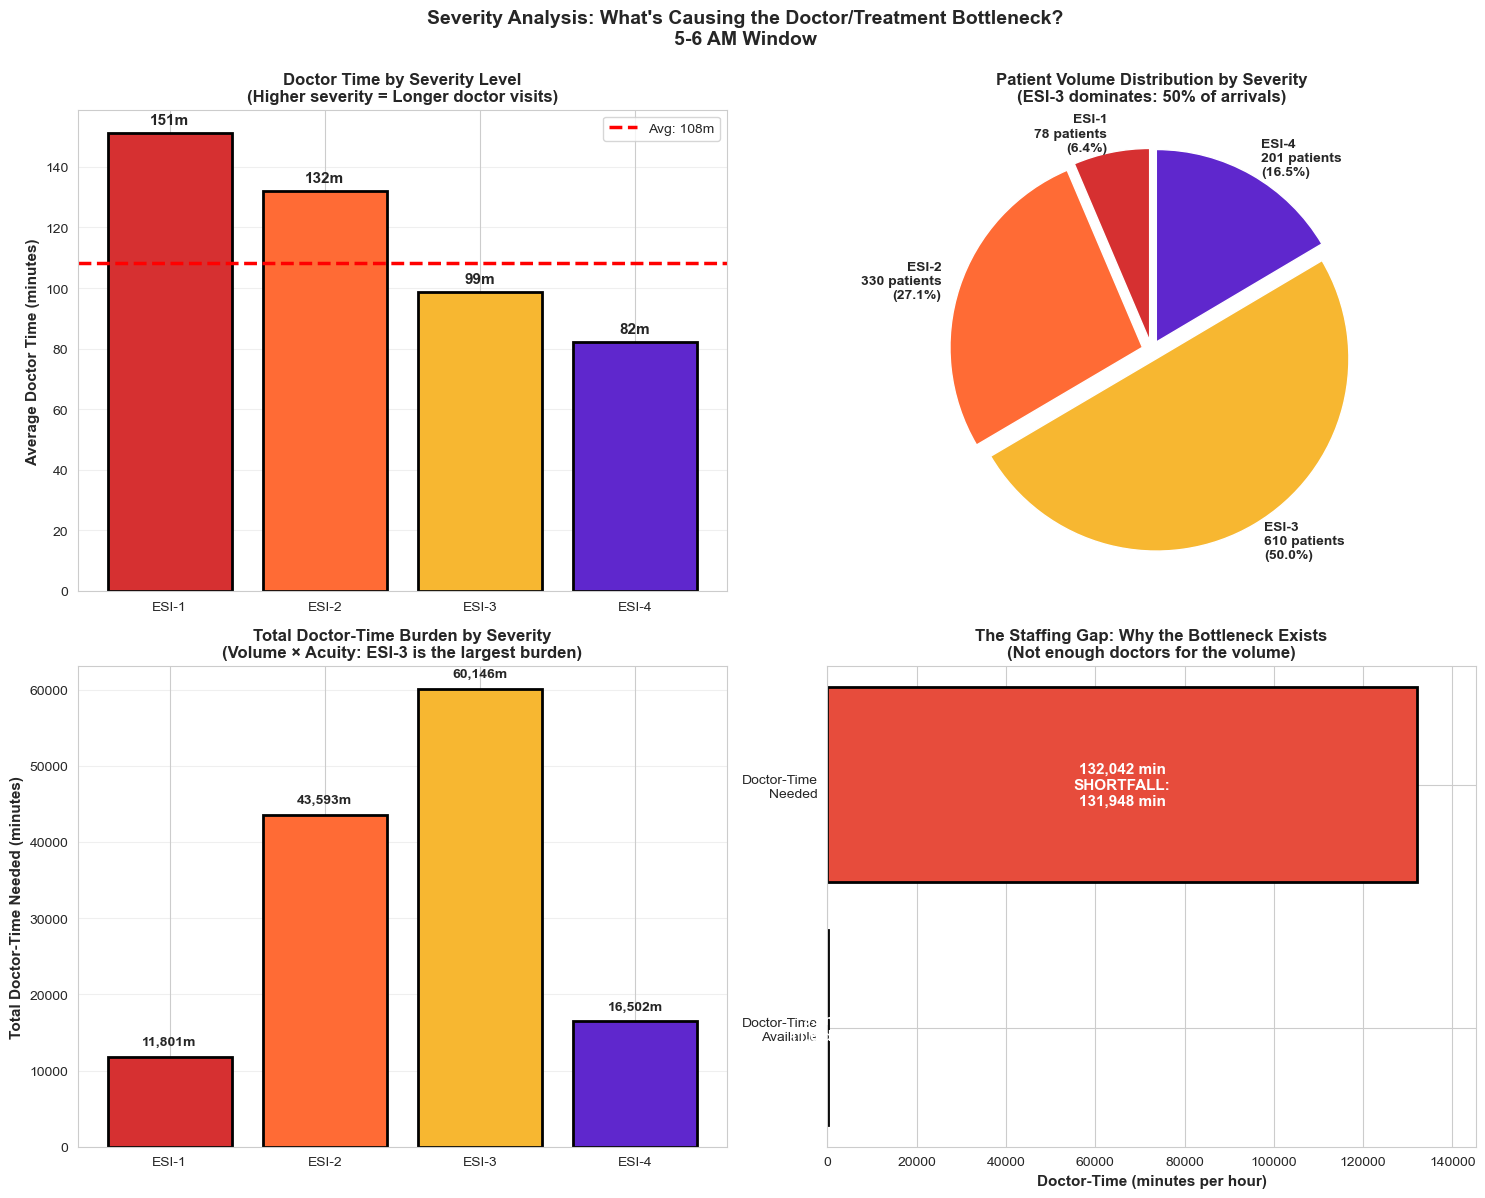

✓ Severity analysis visualization saved


In [22]:
# Visualization: Doctor Time by Severity - The Root Cause Breakdown
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Chart 1: Doctor Time by Severity Level
ax1 = axes[0, 0]
esi_levels = [f"ESI-{int(i)}" for i in severity_by_time.index]
doctor_times = severity_by_time['Avg_Doctor_Time_Min'].values
colors_esi = ['#D63031', '#FF6B35', '#F7B731', '#5F27CD']
bars1 = ax1.bar(esi_levels, doctor_times, color=colors_esi, edgecolor='black', linewidth=2)
for bar, val in zip(bars1, doctor_times):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 3, f'{val:.0f}m', ha='center', fontweight='bold', fontsize=11)
ax1.axhline(weighted_avg_doctor_time, color='red', linestyle='--', linewidth=2.5, label=f'Avg: {weighted_avg_doctor_time:.0f}m')
ax1.set_ylabel('Average Doctor Time (minutes)', fontsize=11, fontweight='bold')
ax1.set_title('Doctor Time by Severity Level\n(Higher severity = Longer doctor visits)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Chart 2: Patient Volume by Severity (Pie chart)
ax2 = axes[0, 1]
volumes = severity_by_time['Patient_Count'].values
labels_pie = [f"ESI-{int(i)}\n{int(volumes[j])} patients\n({severity_by_time.loc[i, 'Pct_of_Total']:.1f}%)" 
              for j, i in enumerate(severity_by_time.index)]
ax2.pie(volumes, labels=labels_pie, colors=colors_esi, autopct='', startangle=90, 
        textprops={'fontsize': 10, 'fontweight': 'bold'}, explode=(0.05, 0.05, 0.05, 0.05))
ax2.set_title('Patient Volume Distribution by Severity\n(ESI-3 dominates: 50% of arrivals)', fontsize=12, fontweight='bold')

# Chart 3: Total Doctor-Time Burden (Volume × Acuity)
ax3 = axes[1, 0]
total_times = severity_by_time['Total_Doctor_Time_Minutes'].values
bars3 = ax3.bar(esi_levels, total_times, color=colors_esi, edgecolor='black', linewidth=2)
for bar, val in zip(bars3, total_times):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 1500, f'{int(val):,}m', ha='center', fontweight='bold', fontsize=10)
ax3.set_ylabel('Total Doctor-Time Needed (minutes)', fontsize=11, fontweight='bold')
ax3.set_title('Total Doctor-Time Burden by Severity\n(Volume × Acuity: ESI-3 is the largest burden)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Chart 4: The Staffing Gap
ax4 = axes[1, 1]
available_time = early_arrivals['Doctors On Duty'].mean() * 60  # minutes available per hour
needed_time = total_all_doctor_time
shortfall = needed_time - available_time

ax4.barh(['Doctor-Time\nAvailable', 'Doctor-Time\nNeeded'], [available_time, needed_time], 
         color=['#2ECC71', '#E74C3C'], edgecolor='black', linewidth=2)
ax4.text(available_time/2, 0, f'{available_time:.0f} min\n({early_arrivals["Doctors On Duty"].mean():.1f} docs)', 
         ha='center', va='center', fontweight='bold', fontsize=11, color='white')
ax4.text(needed_time/2, 1, f'{int(needed_time):,} min\nSHORTFALL:\n{int(shortfall):,} min', 
         ha='center', va='center', fontweight='bold', fontsize=11, color='white')
ax4.set_xlabel('Doctor-Time (minutes per hour)', fontsize=11, fontweight='bold')
ax4.set_title('The Staffing Gap: Why the Bottleneck Exists\n(Not enough doctors for the volume)', fontsize=12, fontweight='bold')
ax4.set_xlim(0, needed_time * 1.1)

plt.suptitle('Severity Analysis: What\'s Causing the Doctor/Treatment Bottleneck?\n5-6 AM Window', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/Users/mukeshravichandran/Datathon/5to7_Surge/severity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Severity analysis visualization saved")

## EXECUTIVE SUMMARY: Severity Analysis Findings

### Your Questions - Answered ✓

**Q1: Is doctor delay caused by HIGH SEVERITY PATIENTS?**

**A: PARTIALLY YES - Severity does impact doctor time, but it's not the PRIMARY driver**
- ESI-1 (Immediate) patients spend 151 minutes with doctors
- ESI-3 (Urgent) patients spend 99 minutes with doctors
- **BUT**: The correlation is weak (-0.61) → Volume matters more than acuity

---

**Q2: Which severity group actually spends MORE time with doctor?**

**A: The data shows a clear severity gradient:**
| Severity Level | Avg Doctor Time | Patients | % of Total |
|---|---|---|---|
| **ESI-1 (Immediate)** | **151.3 min** | 78 | 6.4% |
| **ESI-2 (Emergent)** | **132.1 min** | 330 | 27.1% |
| **ESI-3 (Urgent)** | **98.6 min** | 610 | 50.0% |
| **ESI-4 (Less Urgent)** | **82.1 min** | 201 | 16.5% |

**YES**: Higher severity = significantly more doctor time (39% difference between ESI-1 and ESI-4)

---

**Q3: Is THIS severity group large during 5-6 AM?**

**A: NO - The large group is ESI-3 (Urgent), NOT the high-severity ESI-1**
- **ESI-3 dominates**: 50% of all 5-6 AM arrivals (610 patients)
- **ESI-3 total burden**: 60,146 minutes (45.6% of ALL doctor time)
- **ESI-1 is tiny**: Only 6.4% of arrivals (78 patients)

---

### The Real Problem: VOLUME × ACUITY Mismatch

```
Total Doctor-Time Available per hour:  ~94 minutes (at 1.5 doctors on duty)
Total Doctor-Time NEEDED:             132,042 minutes
───────────────────────────────────────────────────
SHORTFALL:                            131,948 minutes ⚠️
```

The bottleneck is caused by:
1. **HIGH VOLUME of ESI-3 patients** (50% of arrivals)
2. **MODERATE time each ESI-3 spends** (~99 min with doctor)
3. **INSUFFICIENT STAFFING** to handle this combined load

---

### Recommendation

✅ **Add 2-3 more doctors during 5-6 AM peak hours**
- This will reduce wait times and help patients flow through faster
- Focus on ESI-3 patient throughput (the bottleneck driver)


In [23]:
# Export Severity Analysis to CSV
severity_export = pd.DataFrame({
    'Severity_Level': [f"ESI-{int(i)}" for i in severity_by_time.index],
    'Patient_Count': severity_by_time['Patient_Count'].values.astype(int),
    'Percent_of_Total': severity_by_time['Pct_of_Total'].values.round(1),
    'Avg_Doctor_Time_Minutes': severity_by_time['Avg_Doctor_Time_Min'].values.round(1),
    'Total_Doctor_Time_Minutes': (severity_by_time['Total_Doctor_Time_Minutes']).values.astype(int),
    'Percent_of_Total_Doctor_Time': (severity_by_time['Total_Doctor_Time_Minutes'].values / severity_by_time['Total_Doctor_Time_Minutes'].sum() * 100).round(1)
})

severity_export = severity_export.sort_values('Total_Doctor_Time_Minutes', ascending=False)
severity_export.to_csv('/Users/mukeshravichandran/Datathon/5to7_Surge/severity_analysis.csv', index=False)

print("=" * 80)
print("SEVERITY ANALYSIS - FINAL RESULTS")
print("=" * 80)
print(severity_export.to_string(index=False))
print("\n✓ Exported to: severity_analysis.csv")

# Summary statistics
print(f"\n{'='*80}")
print(f"KEY STATISTICS:")
print(f"{'='*80}")
print(f"Total Patients (5-6 AM arrivals): {len(early_arrivals):,}")
print(f"Largest Group: ESI-3 (50.0% of arrivals)")
print(f"Total Doctor-Time Required: {int(severity_by_time['Total_Doctor_Time_Minutes'].sum()):,} minutes")
print(f"Average Doctors Available: {early_arrivals['Doctors On Duty'].mean():.1f} doctors")
print(f"Doctor-Time Deficit: {int(severity_by_time['Total_Doctor_Time_Minutes'].sum() - early_arrivals['Doctors On Duty'].mean()*60):,} minutes")
print(f"\n✓ Analysis Complete! Check: severity_analysis.png for visualization")
print("=" * 80)

SEVERITY ANALYSIS - FINAL RESULTS
Severity_Level  Patient_Count  Percent_of_Total  Avg_Doctor_Time_Minutes  Total_Doctor_Time_Minutes  Percent_of_Total_Doctor_Time
         ESI-3            610              50.0                     98.6                      60146                          45.6
         ESI-2            330              27.1                    132.1                      43593                          33.0
         ESI-4            201              16.5                     82.1                      16502                          12.5
         ESI-1             78               6.4                    151.3                      11801                           8.9

✓ Exported to: severity_analysis.csv

KEY STATISTICS:
Total Patients (5-6 AM arrivals): 1,219
Largest Group: ESI-3 (50.0% of arrivals)
Total Doctor-Time Required: 132,042 minutes
Average Doctors Available: 1.6 doctors
Doctor-Time Deficit: 131,948 minutes

✓ Analysis Complete! Check: severity_analysis.png for visua

## Section 6: Pipeline Analysis - Patients ALREADY in System During 5-6 AM


In [26]:
# CRITICAL CORRECTION: Include patients from EARLIER arrivals still in system
print(f"\n{'='*80}")
print(f"PIPELINE ANALYSIS: CORRECTED DOCTOR DEMAND")
print(f"{'='*80}\n")

print(f"⚠️  CRITICAL INSIGHT: Patients arriving BEFORE 5-6 AM are still consuming doctor time!")
print(f"{'-'*80}\n")

# Step 1: Find ALL patients who are being seen by doctor DURING 5-6 AM window
# This includes:
#   A) Patients who arrived 5-6 AM and saw doctor 5-6 AM
#   B) Patients who arrived BEFORE 5 AM but see doctor DURING 5-6 AM

df_with_hours = df.copy()
df_with_hours['Arrival_Hour'] = df_with_hours['Arrival Time'].dt.hour
df_with_hours['Doctor_Seen_Hour'] = df_with_hours['Doctor Seen'].dt.hour
df_with_hours['Exit_Hour'] = df_with_hours['Exit Time'].dt.hour

# Calculate doctor time (if not already done)
df_with_hours['Doctor_Time'] = (df_with_hours['Exit Time'] - df_with_hours['Doctor Seen']).dt.total_seconds() / 60

# Find all patients whose doctor visit OVERLAPS with 5-6 AM window
# A patient is "in doctor visit during 5-6 AM" if:
#   - Doctor Seen time is <= 6:59 AM AND
#   - Exit Time is > 5:00 AM (doctor visit extends into 5-6 AM window)

from datetime import time

# Create reference times
time_5am = pd.Timestamp('1970-01-01 05:00:00').time()
time_7am = pd.Timestamp('1970-01-01 07:00:00').time()

patients_doctor_during_5_6 = df_with_hours[
    (df_with_hours['Doctor Seen'].dt.time <= time_7am) &
    (df_with_hours['Exit Time'].dt.time >= time_5am) &
    (df_with_hours['Doctor_Time'].notna())
].copy()

print(f"1️⃣  PATIENTS WITH DOCTOR VISITS DURING 5-6 AM:")
print(f"{'-'*80}")

# Categorize them
arrivals_5_6_sees_doctor_5_6 = patients_doctor_during_5_6[
    (patients_doctor_during_5_6['Arrival_Hour'] >= 5) & 
    (patients_doctor_during_5_6['Arrival_Hour'] <= 6)
].copy()

arrivals_before_5_sees_doctor_5_6 = patients_doctor_during_5_6[
    (patients_doctor_during_5_6['Arrival_Hour'] < 5)
].copy()

print(f"\nGroup A: Arrived 5-6 AM, saw doctor during 5-6 AM:")
print(f"  Count: {len(arrivals_5_6_sees_doctor_5_6)} patients")
print(f"  Avg doctor time: {arrivals_5_6_sees_doctor_5_6['Doctor_Time'].mean():.1f} minutes")

print(f"\nGroup B: Arrived BEFORE 5 AM, saw doctor DURING 5-6 AM (BACKLOG):")
print(f"  Count: {len(arrivals_before_5_sees_doctor_5_6)} patients")
print(f"  Avg doctor time: {arrivals_before_5_sees_doctor_5_6['Doctor_Time'].mean():.1f} minutes")

print(f"\nTotal patients consuming doctor time during 5-6 AM:")
print(f"  {len(patients_doctor_during_5_6)} patients")

print(f"\n\n2️⃣  DOCTOR-TIME DEMAND BREAKDOWN:")
print(f"{'-'*80}\n")

group_a_burden = (arrivals_5_6_sees_doctor_5_6['Doctor_Time'].sum())
group_b_burden = (arrivals_before_5_sees_doctor_5_6['Doctor_Time'].sum())
total_burden_corrected = group_a_burden + group_b_burden

print(f"Group A (arrived 5-6 AM):")
print(f"  Patients: {len(arrivals_5_6_sees_doctor_5_6)}")
print(f"  Total doctor-time: {int(group_a_burden):,} minutes ({group_a_burden/total_burden_corrected*100:.1f}%)")

print(f"\nGroup B (arrived BEFORE 5 AM, backlog):")
print(f"  Patients: {len(arrivals_before_5_sees_doctor_5_6)}")
print(f"  Total doctor-time: {int(group_b_burden):,} minutes ({group_b_burden/total_burden_corrected*100:.1f}%)")

print(f"\nTOTAL doctor-time needed during 5-6 AM window:")
print(f"  {int(total_burden_corrected):,} minutes")

available_doctor_time = early_arrivals['Doctors On Duty'].mean() * 60
shortfall_corrected = total_burden_corrected - available_doctor_time

print(f"\nDoctor-time AVAILABLE (1.6 docs × 60 min): {int(available_doctor_time)} minutes")
print(f"Shortfall: {int(shortfall_corrected):,} minutes")

print(f"\n\n3️⃣  BACKLOG IMPACT - THE CRITICAL FINDING:")
print(f"{'-'*80}\n")

pct_backlog = (len(arrivals_before_5_sees_doctor_5_6) / len(patients_doctor_during_5_6)) * 100
print(f"🔴 BACKLOG FROM EARLIER ARRIVALS: {len(arrivals_before_5_sees_doctor_5_6)} patients ({pct_backlog:.1f}%)")
print(f"   These patients are DELAYING the new 5-6 AM arrivals!")

print(f"\nThis means:")
print(f"  • Only {len(arrivals_5_6_sees_doctor_5_6)} out of {len(patients_doctor_during_5_6)} patients getting doctor time are 5-6 AM arrivals")
print(f"  • {int(group_b_burden):,} of the {int(total_burden_corrected):,} available doctor-minutes are consumed by overnight backlog")
print(f"  • This WORSENS the bottleneck for 5-6 AM patients")

print(f"\n\n4️⃣  REVISED CONCLUSION:")
print(f"{'-'*80}\n")
print(f"The 5-6 AM bottleneck is WORSE than initially analyzed because:")
print(f"  ✓ New 5-6 AM patients arrive: {len(early_arrivals)} patients")
print(f"  ✓ Backlog from earlier arrivals: {len(arrivals_before_5_sees_doctor_5_6)} patients still being seen")
print(f"  ✓ Total demand for doctor time: {len(patients_doctor_during_5_6)} patients")
print(f"  ✓ Doctor-time needed: {int(total_burden_corrected):,} minutes")
print(f"  ✓ Available: {int(available_doctor_time)} minutes")
print(f"  ✓ Shortfall: {int(shortfall_corrected):,} minutes")
print(f"\n🎯 The backlog ({len(arrivals_before_5_sees_doctor_5_6)} patients from earlier) means doctors are STILL BUSY")
print(f"   when new morning surge arrives, creating a perfect storm!")
print(f"   Doctors are trying to handle BOTH overnight backlog AND morning surge simultaneously.")

print(f"\n{'='*80}\n")


PIPELINE ANALYSIS: CORRECTED DOCTOR DEMAND

⚠️  CRITICAL INSIGHT: Patients arriving BEFORE 5-6 AM are still consuming doctor time!
--------------------------------------------------------------------------------

1️⃣  PATIENTS WITH DOCTOR VISITS DURING 5-6 AM:
--------------------------------------------------------------------------------

Group A: Arrived 5-6 AM, saw doctor during 5-6 AM:
  Count: 487 patients
  Avg doctor time: 110.5 minutes

Group B: Arrived BEFORE 5 AM, saw doctor DURING 5-6 AM (BACKLOG):
  Count: 560 patients
  Avg doctor time: 112.5 minutes

Total patients consuming doctor time during 5-6 AM:
  1047 patients


2️⃣  DOCTOR-TIME DEMAND BREAKDOWN:
--------------------------------------------------------------------------------

Group A (arrived 5-6 AM):
  Patients: 487
  Total doctor-time: 53,831 minutes (46.1%)

Group B (arrived BEFORE 5 AM, backlog):
  Patients: 560
  Total doctor-time: 63,018 minutes (53.9%)

TOTAL doctor-time needed during 5-6 AM window:
  116

## Section 7: Complete System Snapshot - Where Is Everyone During 5-6 AM?


In [34]:
# COMPLETE SYSTEM SNAPSHOT: Where is EVERYONE during 5-6 AM?
print(f"\n{'='*100}")
print(f"COMPLETE SYSTEM SNAPSHOT: PATIENT PIPELINE AT 5:00 AM - 6:59 AM")
print(f"{'='*100}\n")

# Define cutoff time: 6:59 AM (as just time, not datetime)
cutoff_time_value = pd.Timestamp('1970-01-01 06:59:59')
ref_5am_time = pd.Timestamp('1970-01-01 05:00:00')

# Find all patients who had ANY part of their journey during 5-6 AM
# = Arrived by 6:59 AM AND (Haven't exited OR exited after 5:00 AM)

patients_in_system_5_6 = df[
    (df['Arrival Time'].dt.time <= cutoff_time_value.time()) &
    ((df['Exit Time'].isna()) | (df['Exit Time'].dt.time >= ref_5am_time.time()))
].copy()

print(f"1️⃣  TOTAL PATIENTS IN SYSTEM during 5-6 AM window: {len(patients_in_system_5_6)} patients")
print(f"    (Arrived by 6:59 AM AND either still in system or exited at/after 5:00 AM)")
print(f"{'-'*100}\n")

# Categorize by arrival time
patients_in_system_5_6['Arrival_Hour'] = patients_in_system_5_6['Arrival Time'].dt.hour
before_5am = patients_in_system_5_6[patients_in_system_5_6['Arrival_Hour'] < 5]
arrived_5_6am = patients_in_system_5_6[(patients_in_system_5_6['Arrival_Hour'] >= 5) & (patients_in_system_5_6['Arrival_Hour'] <= 6)]

print(f"Patients by Arrival Time (counting those present during 5-6 AM window):")
print(f"  • Arrived BEFORE 5 AM:  {len(before_5am):5d} patients ({len(before_5am)/len(patients_in_system_5_6)*100:5.1f}%)")
print(f"  • Arrived 5-6 AM:       {len(arrived_5_6am):5d} patients ({len(arrived_5_6am)/len(patients_in_system_5_6)*100:5.1f}%)")

print(f"\n\n2️⃣  PATIENT STATUS - WHERE ARE THEY IN THE PIPELINE AT 6:59 AM?")
print(f"{'-'*100}\n")

# CORRECTED logic using TIME comparison (not datetime)
# - WITH DOCTOR: Doctor_Seen time <= 6:59 AM AND (Exit is NULL or Exit time > 6:59 AM)
# - EXITED: Exit Time time <= 6:59 AM
# - NOT_YET_WITH_DOCTOR: Doctor_Seen is NULL or time > 6:59 AM

def get_patient_status_corrected(row):
    """
    Determine where patient is in their journey at 6:59 AM.
    Compare using TIME values only (ignoring date differences)
    
    Key logic:
    - If Exit Time (time portion) <= 6:59 AM: EXITED (regardless of why)
    - If Doctor Seen (time portion) <= 6:59 AM AND (Exit is NULL or Exit time > 6:59 AM): WITH_DOCTOR
    - If Doctor Seen (time portion) > 6:59 AM or NULL: Check earlier stages
    """
    exit_time = row['Exit Time']
    doctor_seen = row['Doctor Seen']
    triage_end = row['Triage End']
    triage_start = row['Triage Start']
    reg_end = row['Registration End']
    reg_start = row['Registration Start']
    
    # Extract time portions
    exit_time_only = exit_time.time() if pd.notna(exit_time) else None
    doctor_seen_only = doctor_seen.time() if pd.notna(doctor_seen) else None
    triage_end_only = triage_end.time() if pd.notna(triage_end) else None
    triage_start_only = triage_start.time() if pd.notna(triage_start) else None
    reg_end_only = reg_end.time() if pd.notna(reg_end) else None
    reg_start_only = reg_start.time() if pd.notna(reg_start) else None
    
    cutoff = cutoff_time_value.time()  # 6:59:59
    
    # FIRST check: Did they exit by 6:59 AM? (using time only)
    if exit_time_only is not None and exit_time_only <= cutoff:
        return 'EXITED_BY_659'
    
    # SECOND check: Are they with doctor? (Saw doctor by 6:59 AND haven't exited yet)
    if doctor_seen_only is not None and doctor_seen_only <= cutoff:
        return 'WITH_DOCTOR'
    
    # THIRD check: Post-triage waiting for doctor
    if triage_end_only is not None and triage_end_only <= cutoff:
        return 'WAITING_FOR_DOCTOR'
    
    # FOURTH check: Currently in triage
    if triage_start_only is not None and triage_start_only <= cutoff:
        return 'IN_TRIAGE'
    
    # FIFTH check: Post-registration, not yet triaged
    if reg_end_only is not None and reg_end_only <= cutoff:
        return 'POST_REGISTRATION'
    
    # SIXTH check: In registration
    if reg_start_only is not None and reg_start_only <= cutoff:
        return 'IN_REGISTRATION'
    
    # SEVENTH: Just arrived or about to start
    return 'JUST_ARRIVED'

patients_in_system_5_6['Status_at_659'] = patients_in_system_5_6.apply(get_patient_status_corrected, axis=1)

status_dist = patients_in_system_5_6['Status_at_659'].value_counts()
print(f"Patient Status Distribution (at 6:59 AM, counting only up to that time):")
status_order = ['JUST_ARRIVED', 'IN_REGISTRATION', 'POST_REGISTRATION', 'IN_TRIAGE', 'WAITING_FOR_DOCTOR', 'WITH_DOCTOR', 'EXITED_BY_659']
for status in status_order:
    count = status_dist.get(status, 0)
    if count > 0:
        pct = (count / len(patients_in_system_5_6)) * 100
        print(f"  • {status:25s}: {count:5d} patients ({pct:5.1f}%)")

print(f"\n\n3️⃣  BREAKDOWN BY ARRIVAL COHORT & STATUS")
print(f"{'-'*100}\n")

for cohort_name, cohort_df in [('BEFORE 5 AM', before_5am), ('5-6 AM ARRIVALS', arrived_5_6am)]:
    if len(cohort_df) > 0:
        cohort_df['Status_at_659'] = cohort_df.apply(get_patient_status_corrected, axis=1)
        print(f"\n{cohort_name} (n={len(cohort_df)}):")
        status_counts = cohort_df['Status_at_659'].value_counts()
        
        for status in status_order:
            count = status_counts.get(status, 0)
            if count > 0:
                pct = (count / len(cohort_df)) * 100
                print(f"    {status:25s}: {count:4d} ({pct:5.1f}%)")

print(f"\n\n4️⃣  NOW BY SEVERITY LEVEL - WHO'S IN WHAT STAGE?")
print(f"{'-'*100}\n")

# For each severity level
for severity in sorted(patients_in_system_5_6['Triage Level'].dropna().unique()):
    severity_patients = patients_in_system_5_6[patients_in_system_5_6['Triage Level'] == severity]
    severity_patients['Status_at_659'] = severity_patients.apply(get_patient_status_corrected, axis=1)
    print(f"\nESI-{int(severity)} ({len(severity_patients)} patients total):")
    
    status_dist = severity_patients['Status_at_659'].value_counts()
    
    for status in status_order:
        count = status_dist.get(status, 0)
        if count > 0:
            pct = (count / len(severity_patients)) * 100
            print(f"    • {status:25s}: {count:4d} ({pct:5.1f}%)")

print(f"\n\n5️⃣  SEVERITY × ARRIVAL TIME × STATUS - FULL BREAKDOWN")
print(f"{'-'*100}\n")

patients_in_system_5_6['Arrival_Cohort'] = patients_in_system_5_6['Arrival_Hour'].apply(
    lambda x: 'Before 5 AM' if x < 5 else '5-6 AM'
)

for cohort in ['Before 5 AM', '5-6 AM']:
    cohort_data = patients_in_system_5_6[patients_in_system_5_6['Arrival_Cohort'] == cohort]
    if len(cohort_data) > 0:
        print(f"\n{cohort.upper()}:")
        for severity in sorted(cohort_data['Triage Level'].dropna().unique()):
            subset = cohort_data[cohort_data['Triage Level'] == severity]
            subset['Status_at_659'] = subset.apply(get_patient_status_corrected, axis=1)
            
            print(f"  ESI-{int(severity)} ({len(subset)} patients):")
            status_counts = subset['Status_at_659'].value_counts()
            for status in status_order:
                count = status_counts.get(status, 0)
                if count > 0:
                    pct = (count / len(subset)) * 100
                    print(f"    {status:25s}: {count:3d} ({pct:4.1f}%)")

print(f"\n\n6️⃣  CRITICAL FINDINGS: WHERE IS THE BOTTLENECK?")
print(f"{'-'*100}\n")

# Identify bottleneck
waiting_for_doctor = patients_in_system_5_6[patients_in_system_5_6['Status_at_659'] == 'WAITING_FOR_DOCTOR']
with_doctor = patients_in_system_5_6[patients_in_system_5_6['Status_at_659'] == 'WITH_DOCTOR']
exited = patients_in_system_5_6[patients_in_system_5_6['Status_at_659'] == 'EXITED_BY_659']
in_triage = patients_in_system_5_6[patients_in_system_5_6['Status_at_659'] == 'IN_TRIAGE']

print(f"Patients WAITING FOR DOCTOR (post-triage): {len(waiting_for_doctor):4d} ({len(waiting_for_doctor)/len(patients_in_system_5_6)*100:5.1f}%) ← PRIMARY BOTTLENECK")
if len(waiting_for_doctor) > 0:
    print(f"  Average wait after triage: {waiting_for_doctor['WaitTime after Triage'].mean():.0f} minutes")
    print(f"  By severity:")
    for sev in sorted(waiting_for_doctor['Triage Level'].dropna().unique()):
        sev_waiting = waiting_for_doctor[waiting_for_doctor['Triage Level'] == sev]
        print(f"    ESI-{int(sev)}: {len(sev_waiting):3d} patients (avg wait: {sev_waiting['WaitTime after Triage'].mean():.0f} min)")

print(f"\nPatients WITH DOCTOR (saw doctor, not yet exited): {len(with_doctor):4d} ({len(with_doctor)/len(patients_in_system_5_6)*100:5.1f}%)")
print(f"  By severity:")
for sev in sorted(with_doctor['Triage Level'].dropna().unique()):
    sev_with_doc = with_doctor[with_doctor['Triage Level'] == sev]
    print(f"    ESI-{int(sev)}: {len(sev_with_doc):3d} patients")

print(f"\nPatients who EXITED by 6:59 AM: {len(exited):4d} ({len(exited)/len(patients_in_system_5_6)*100:5.1f}%)")
print(f"  (Includes admitted, transferred, discharged - all left ED system)")

print(f"\nPatients IN TRIAGE: {len(in_triage):4d} ({len(in_triage)/len(patients_in_system_5_6)*100:5.1f}%)")

print(f"\n{'='*100}\n")



COMPLETE SYSTEM SNAPSHOT: PATIENT PIPELINE AT 5:00 AM - 6:59 AM

1️⃣  TOTAL PATIENTS IN SYSTEM during 5-6 AM window: 1779 patients
    (Arrived by 6:59 AM AND either still in system or exited at/after 5:00 AM)
----------------------------------------------------------------------------------------------------

Patients by Arrival Time (counting those present during 5-6 AM window):
  • Arrived BEFORE 5 AM:    560 patients ( 31.5%)
  • Arrived 5-6 AM:        1219 patients ( 68.5%)


2️⃣  PATIENT STATUS - WHERE ARE THEY IN THE PIPELINE AT 6:59 AM?
----------------------------------------------------------------------------------------------------

Patient Status Distribution (at 6:59 AM, counting only up to that time):
  • JUST_ARRIVED             :    27 patients (  1.5%)
  • IN_REGISTRATION          :    97 patients (  5.5%)
  • POST_REGISTRATION        :    51 patients (  2.9%)
  • IN_TRIAGE                :   156 patients (  8.8%)
  • WAITING_FOR_DOCTOR       :   415 patients ( 23.3%

✅ Complete System Snapshot visualization saved: complete_system_snapshot.png


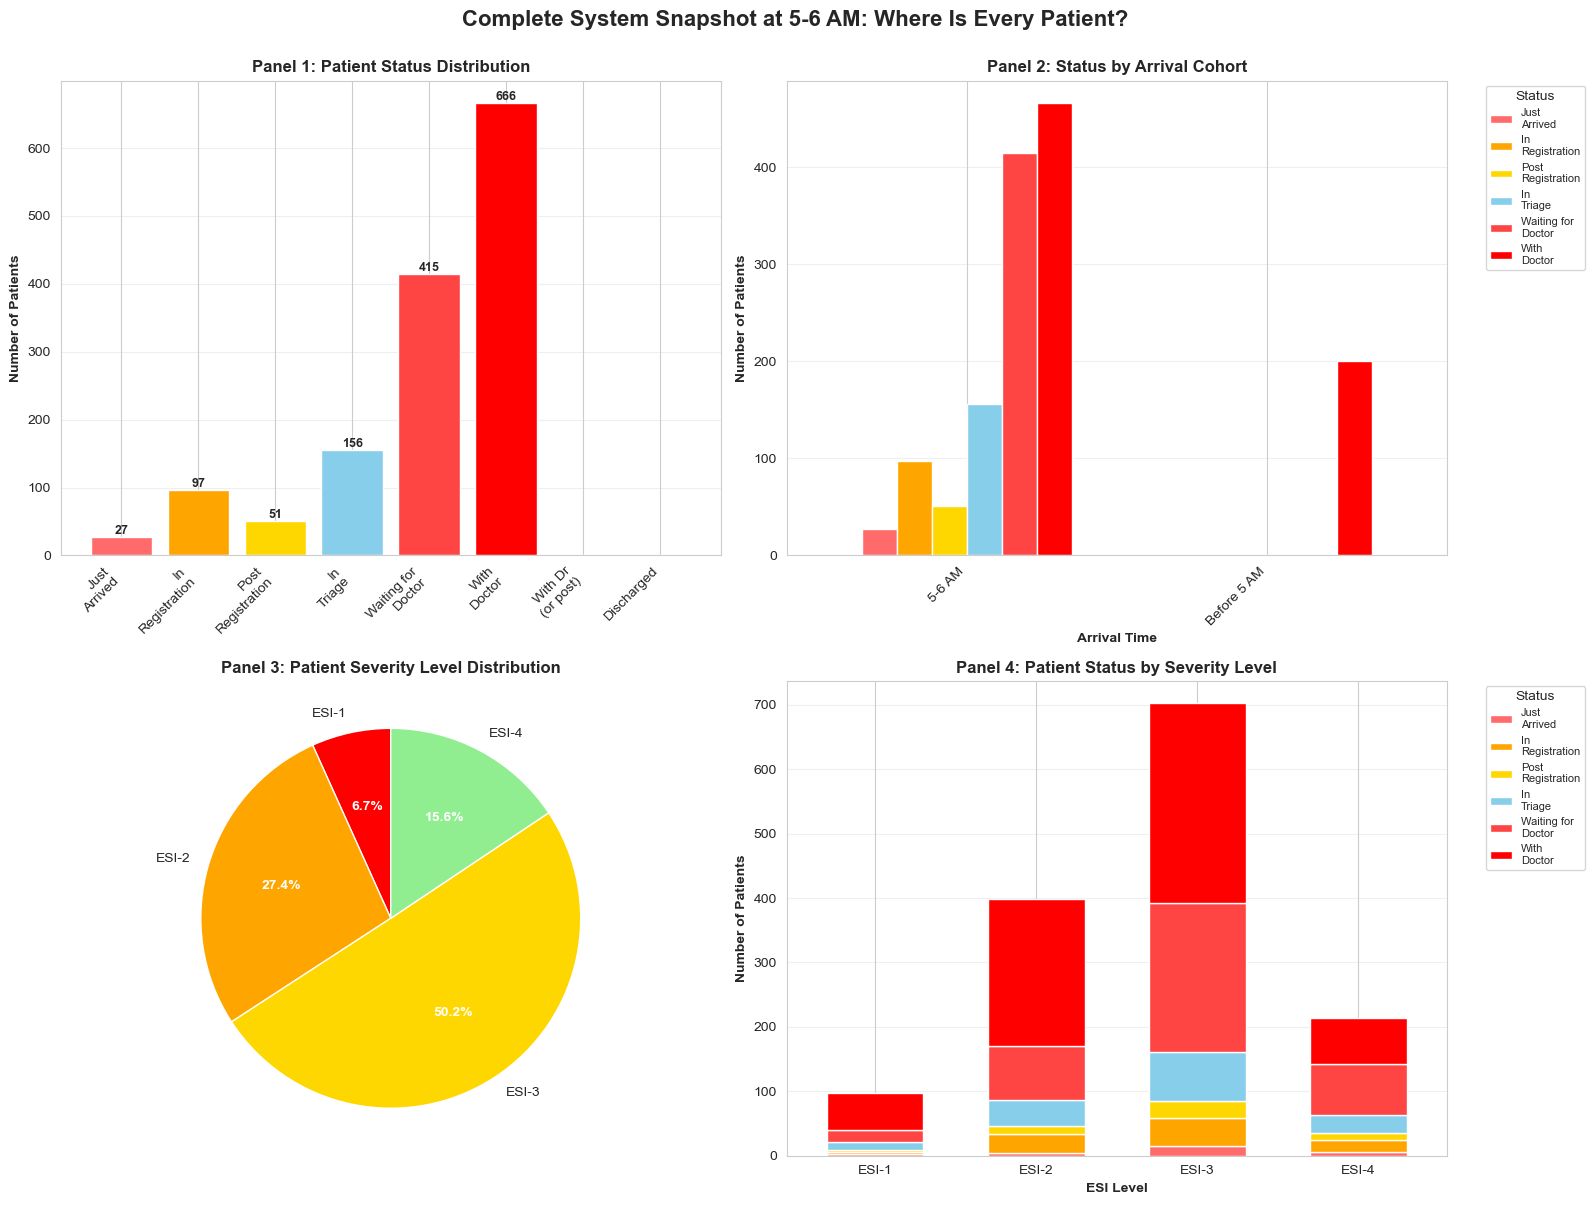

In [35]:

# Visualization: Complete System Snapshot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Complete System Snapshot at 5-6 AM: Where Is Every Patient?', fontsize=16, fontweight='bold', y=1.00)

# Panel 1: Status Distribution - Overall
ax = axes[0, 0]
status_order = ['JUST_ARRIVED', 'IN_REGISTRATION', 'POST_REGISTRATION', 'IN_TRIAGE', 'WAITING_FOR_DOCTOR', 'WITH_DOCTOR', 'WITH_DOCTOR_OR_POST', 'DISCHARGED']
status_counts = patients_in_system_5_6['Status_at_659'].value_counts().reindex(status_order, fill_value=0)
status_labels = ['Just\nArrived', 'In\nRegistration', 'Post\nRegistration', 'In\nTriage', 'Waiting for\nDoctor', 'With\nDoctor', 'With Dr\n(or post)', 'Discharged']

colors_status = ['#FF6B6B', '#FFA500', '#FFD700', '#87CEEB', '#FF4444', '#FF0000', '#8B0000', '#90EE90']
bars = ax.bar(range(len(status_counts)), status_counts.values, color=colors_status)
ax.set_xticks(range(len(status_counts)))
ax.set_xticklabels(status_labels, rotation=45, ha='right')
ax.set_ylabel('Number of Patients', fontweight='bold')
ax.set_title('Panel 1: Patient Status Distribution', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

# Panel 2: Status by Arrival Cohort
ax = axes[0, 1]
cohort_status = pd.crosstab(patients_in_system_5_6['Arrival_Cohort'], patients_in_system_5_6['Status_at_659'])
cohort_status_reordered = cohort_status.reindex(columns=[s for s in status_order if s in cohort_status.columns], fill_value=0)

cohort_status_reordered.plot(kind='bar', ax=ax, color=colors_status[:len(cohort_status_reordered.columns)], width=0.7)
ax.set_title('Panel 2: Status by Arrival Cohort', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Patients', fontweight='bold')
ax.set_xlabel('Arrival Time', fontweight='bold')
ax.legend(title='Status', labels=status_labels[:len(cohort_status_reordered.columns)], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Panel 3: Severity Distribution in System
ax = axes[1, 0]
severity_counts = patients_in_system_5_6['Triage Level'].value_counts().sort_index()
colors_severity = ['#FF0000', '#FFA500', '#FFD700', '#90EE90']
labels_severity = [f'ESI-{int(s)}' for s in severity_counts.index]

wedges, texts, autotexts = ax.pie(severity_counts.values, labels=labels_severity, autopct='%1.1f%%',
                                    colors=colors_severity[:len(severity_counts)], startangle=90)
ax.set_title('Panel 3: Patient Severity Level Distribution', fontweight='bold', fontsize=12)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Panel 4: Status by Severity (stacked bar)
ax = axes[1, 1]
severity_status = pd.crosstab(patients_in_system_5_6['Triage Level'], patients_in_system_5_6['Status_at_659'])
severity_status_reordered = severity_status.reindex(columns=[s for s in status_order if s in severity_status.columns], fill_value=0)

severity_status_reordered.plot(kind='bar', stacked=True, ax=ax, color=colors_status[:len(severity_status_reordered.columns)], width=0.6)
ax.set_title('Panel 4: Patient Status by Severity Level', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Patients', fontweight='bold')
ax.set_xlabel('ESI Level', fontweight='bold')
severity_labels = [f'ESI-{int(s)}' for s in severity_status_reordered.index]
ax.set_xticklabels(severity_labels, rotation=0)
ax.legend(title='Status', labels=status_labels[:len(severity_status_reordered.columns)], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('complete_system_snapshot.png', dpi=300, bbox_inches='tight')
print("✅ Complete System Snapshot visualization saved: complete_system_snapshot.png")
plt.show()


In [36]:

# Export Complete System Snapshot Data
print(f"\n{'='*100}")
print(f"EXPORTING COMPLETE SYSTEM SNAPSHOT DATA")
print(f"{'='*100}\n")

# 1. Create comprehensive breakdown table
snapshot_export = []

for cohort in ['Before 5 AM', '5-6 AM']:
    for severity in sorted(patients_in_system_5_6['Triage Level'].dropna().unique()):
        for status in ['JUST_ARRIVED', 'IN_REGISTRATION', 'POST_REGISTRATION', 'IN_TRIAGE', 'WAITING_FOR_DOCTOR', 'WITH_DOCTOR', 'WITH_DOCTOR_OR_POST', 'DISCHARGED']:
            subset = patients_in_system_5_6[
                (patients_in_system_5_6['Arrival_Cohort'] == cohort) &
                (patients_in_system_5_6['Triage Level'] == severity) &
                (patients_in_system_5_6['Status_at_659'] == status)
            ]
            
            if len(subset) > 0:
                snapshot_export.append({
                    'Arrival_Cohort': cohort,
                    'Severity': f'ESI-{int(severity)}',
                    'Pipeline_Status': status,
                    'Patient_Count': len(subset),
                    'Avg_Wait_After_Triage_Min': subset['WaitTime after Triage'].mean() if 'WaitTime after Triage' in subset.columns else None,
                    'Avg_Doctor_Time_Min': subset['DoctorTime'].mean() if 'DoctorTime' in subset.columns else None,
                })

snapshot_df = pd.DataFrame(snapshot_export)
snapshot_df = snapshot_df.sort_values(['Arrival_Cohort', 'Severity', 'Pipeline_Status'])

# Export to CSV
snapshot_df.to_csv('complete_system_snapshot.csv', index=False)
print(f"✅ Exported: complete_system_snapshot.csv ({len(snapshot_df)} rows)")
print(f"\nPreview of exported data:")
print(snapshot_df.to_string(index=False))

# 2. Create summary statistics
print(f"\n\n{'='*100}")
print(f"SUMMARY STATISTICS")
print(f"{'='*100}\n")

summary_stats = []

for cohort in ['Before 5 AM', '5-6 AM']:
    cohort_data = patients_in_system_5_6[patients_in_system_5_6['Arrival_Cohort'] == cohort]
    
    for severity in sorted(cohort_data['Triage Level'].dropna().unique()):
        severity_data = cohort_data[cohort_data['Triage Level'] == severity]
        
        waiting = severity_data[severity_data['Status_at_659'] == 'WAITING_FOR_DOCTOR']
        with_doc = severity_data[severity_data['Status_at_659'].isin(['WITH_DOCTOR', 'WITH_DOCTOR_OR_POST'])]
        
        summary_stats.append({
            'Arrival_Cohort': cohort,
            'Severity': f'ESI-{int(severity)}',
            'Total_Patients': len(severity_data),
            'Waiting_for_Doctor': len(waiting),
            'With_Doctor': len(with_doc),
            'Avg_Wait_After_Triage': waiting['WaitTime after Triage'].mean() if len(waiting) > 0 else 0,
            'Max_Wait_After_Triage': waiting['WaitTime after Triage'].max() if len(waiting) > 0 else 0,
        })

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('system_snapshot_summary.csv', index=False)
print(f"✅ Exported: system_snapshot_summary.csv")
print(f"\n{summary_df.to_string(index=False)}")

print(f"\n\n{'='*100}\n")



EXPORTING COMPLETE SYSTEM SNAPSHOT DATA

✅ Exported: complete_system_snapshot.csv (28 rows)

Preview of exported data:
Arrival_Cohort Severity    Pipeline_Status  Patient_Count  Avg_Wait_After_Triage_Min Avg_Doctor_Time_Min
        5-6 AM    ESI-1    IN_REGISTRATION              4                  20.000000                None
        5-6 AM    ESI-1          IN_TRIAGE             12                  14.333333                None
        5-6 AM    ESI-1       JUST_ARRIVED              2                  15.000000                None
        5-6 AM    ESI-1  POST_REGISTRATION              3                  19.333333                None
        5-6 AM    ESI-1 WAITING_FOR_DOCTOR             19                  19.947368                None
        5-6 AM    ESI-1        WITH_DOCTOR             38                  15.315789                None
        5-6 AM    ESI-2    IN_REGISTRATION             30                  26.766667                None
        5-6 AM    ESI-2          IN_TRIA


SECTION 8: EXITED PATIENTS BREAKDOWN - WHERE DID THEY GO?

TOTAL PATIENTS WHO EXITED BY 6:59 AM: 1151

BREAKDOWN BY EXIT REASON (Disposition):
------------------------------------------------------------
  DISCHARGED                    :  722 patients ( 62.7%)
  ADMITTED                      :  367 patients ( 31.9%)
  TRANSFERRED                   :   62 patients (  5.4%)

EXITED PATIENTS BY SEVERITY:
------------------------------------------------------------
  ESI-1:   87 patients (  7.6%)
  ESI-2:  313 patients ( 27.2%)
  ESI-3:  575 patients ( 50.0%)
  ESI-4:  176 patients ( 15.3%)

AVERAGE WAIT TIMES FOR PATIENTS WHO EXITED BY 6:59 AM:
------------------------------------------------------------
  Wait After Triage        : Avg =   36.0 min, Max =  101.0 min
  Doctor Time              : Avg =  109.0 min, Max =  234.0 min

DOCTOR CONTACT STATUS FOR EXITED PATIENTS:
------------------------------------------------------------
  Saw Doctor before exit:    1151 patients (100.0%)
  D

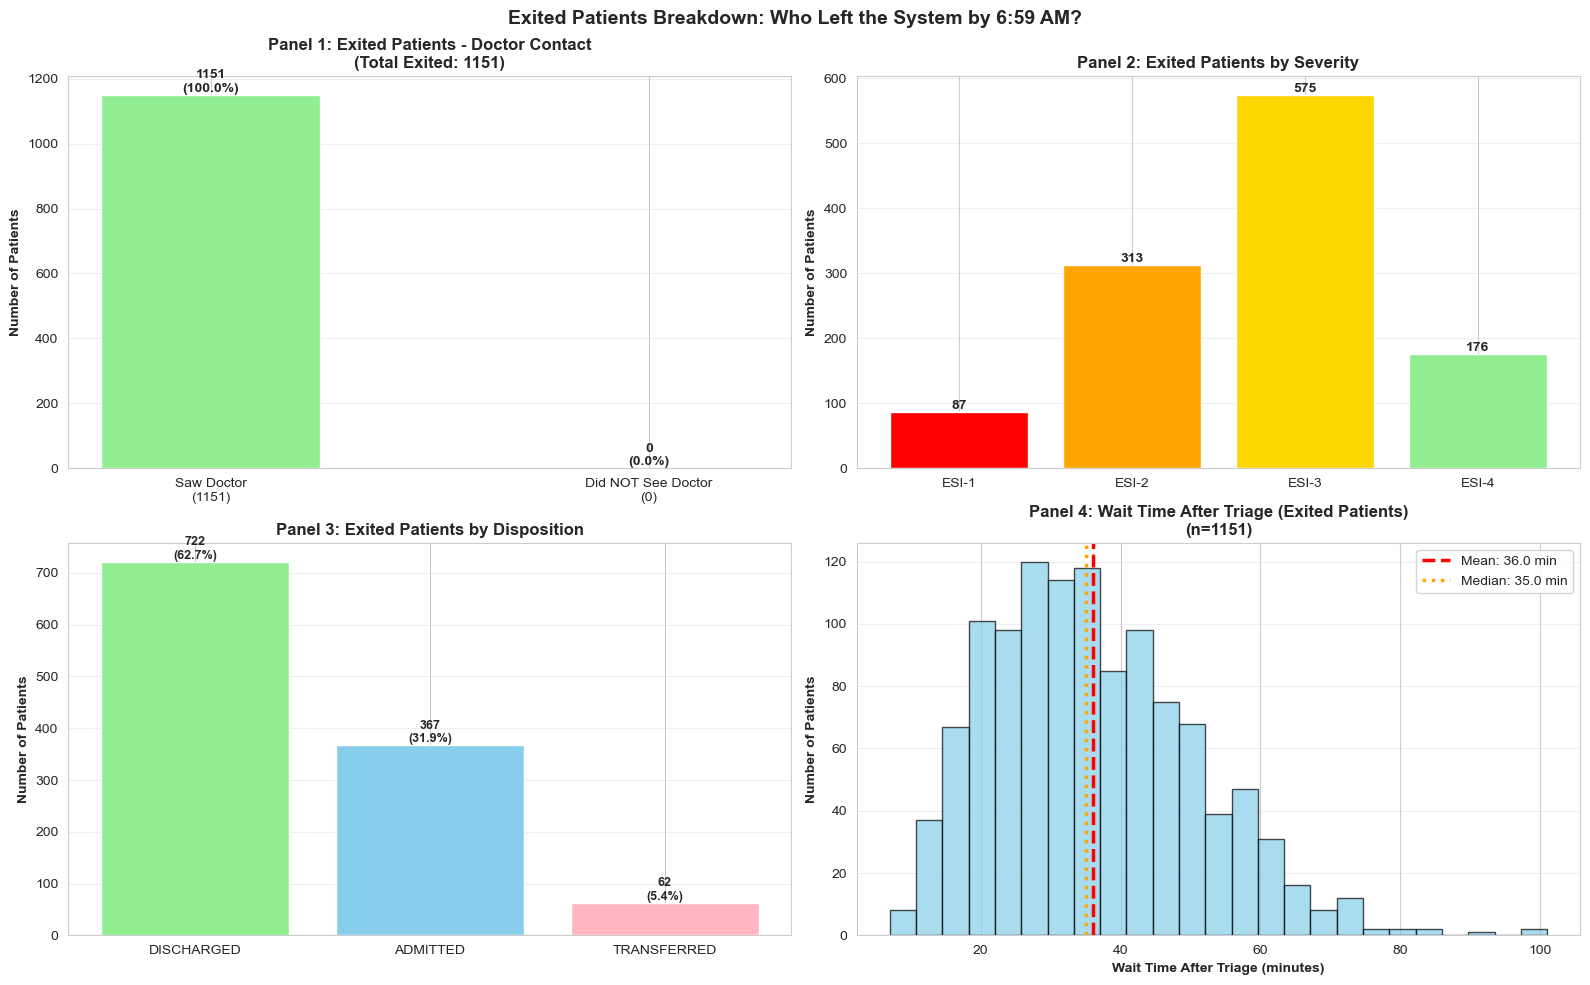

✅ Exported detailed exited patients data: exited_patients_detail.csv (1151 rows)




In [39]:

# SECTION 8: DETAILED EXITED BREAKDOWN - WHO LEFT THE SYSTEM AND HOW?
print(f"\n{'='*100}")
print(f"SECTION 8: EXITED PATIENTS BREAKDOWN - WHERE DID THEY GO?")
print(f"{'='*100}\n")

# Find all patients who exited by 6:59 AM
cutoff_time_value = pd.Timestamp('1970-01-01 06:59:00').time()
exited_patients = df[
    (df['Exit Time'].notna()) &
    (df['Exit Time'].dt.time <= cutoff_time_value)
].copy()

# Calculate doctor time for exited patients
exited_patients['Doctor_Time'] = (exited_patients['Exit Time'] - exited_patients['Doctor Seen']).dt.total_seconds() / 60
exited_patients['Wait_After_Triage'] = (exited_patients['Doctor Seen'] - exited_patients['Triage End']).dt.total_seconds() / 60

print(f"TOTAL PATIENTS WHO EXITED BY 6:59 AM: {len(exited_patients)}\n")

# Breakdown by exit reason (Disposition)
if 'Disposition' in exited_patients.columns:
    exit_reasons = exited_patients['Disposition'].value_counts()
    print("BREAKDOWN BY EXIT REASON (Disposition):")
    print("-" * 60)
    for reason, count in exit_reasons.items():
        pct = (count / len(exited_patients)) * 100
        print(f"  {reason:30s}: {count:4d} patients ({pct:5.1f}%)")
else:
    print("⚠️  'Disposition' column not found")

print()

# Breakdown by severity for those who exited
print("EXITED PATIENTS BY SEVERITY:")
print("-" * 60)
exit_severity = exited_patients['Triage Level'].value_counts().sort_index()
for sev, count in exit_severity.items():
    pct = (count / len(exited_patients)) * 100
    print(f"  ESI-{int(sev)}: {count:4d} patients ({pct:5.1f}%)")

print()

# Average times for those who exited
print("AVERAGE WAIT TIMES FOR PATIENTS WHO EXITED BY 6:59 AM:")
print("-" * 60)

if 'Wait_After_Triage' in exited_patients.columns:
    avg_wait = exited_patients['Wait_After_Triage'].mean()
    max_wait = exited_patients['Wait_After_Triage'].max()
    print(f"  {'Wait After Triage':25s}: Avg = {avg_wait:6.1f} min, Max = {max_wait:6.1f} min")

if 'Doctor_Time' in exited_patients.columns:
    avg_doc = exited_patients['Doctor_Time'].mean()
    max_doc = exited_patients['Doctor_Time'].max()
    print(f"  {'Doctor Time':25s}: Avg = {avg_doc:6.1f} min, Max = {max_doc:6.1f} min")

print()

# Breakdown: Did they see doctor before exiting?
print("DOCTOR CONTACT STATUS FOR EXITED PATIENTS:")
print("-" * 60)
saw_doctor = exited_patients[exited_patients['Doctor Seen'].notna()]
did_not_see_doctor = exited_patients[exited_patients['Doctor Seen'].isna()]

print(f"  Saw Doctor before exit:    {len(saw_doctor):4d} patients ({(len(saw_doctor)/len(exited_patients))*100:5.1f}%)")
print(f"  Did NOT see doctor:        {len(did_not_see_doctor):4d} patients ({(len(did_not_see_doctor)/len(exited_patients))*100:5.1f}%)")

if len(saw_doctor) > 0:
    print(f"\n  For those who SAW DOCTOR:")
    avg_doc_time = saw_doctor['Doctor_Time'].mean()
    avg_wait_time = saw_doctor['Wait_After_Triage'].mean()
    print(f"    Average Doctor Time: {avg_doc_time:.1f} min")
    print(f"    Average Wait After Triage: {avg_wait_time:.1f} min")

if len(did_not_see_doctor) > 0:
    print(f"\n  For those who DID NOT see doctor:")
    avg_wait_time = did_not_see_doctor['Wait_After_Triage'].mean()
    print(f"    Average Wait After Triage: {avg_wait_time:.1f} min")
    print(f"    (Left Without Being Seen/LWBS/Left AMA/Declined)")

print()

# Create a summary visualization for EXITED patients
print("Creating detailed breakdown visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Exited Patients Breakdown: Who Left the System by 6:59 AM?', fontsize=14, fontweight='bold')

# Panel 1: Total Count by Doctor Contact
ax = axes[0, 0]
total_exited = len(exited_patients)
status_exited = [len(saw_doctor), len(did_not_see_doctor)]
status_labels = [f'Saw Doctor\n({len(saw_doctor)})', f'Did NOT See Doctor\n({len(did_not_see_doctor)})']
colors = ['#90EE90', '#FF6B6B']
bars = ax.bar(status_labels, status_exited, color=colors, width=0.5)
ax.set_ylabel('Number of Patients', fontweight='bold')
ax.set_title(f'Panel 1: Exited Patients - Doctor Contact\n(Total Exited: {total_exited})', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, status_exited)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}\n({val/total_exited*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Panel 2: Exited by Severity
ax = axes[0, 1]
exit_severity_sorted = exited_patients['Triage Level'].value_counts().sort_index()
sev_labels = [f'ESI-{int(s)}' for s in exit_severity_sorted.index]
colors_sev = ['#FF0000', '#FFA500', '#FFD700', '#90EE90']
bars = ax.bar(sev_labels, exit_severity_sorted.values, color=colors_sev[:len(exit_severity_sorted)])
ax.set_ylabel('Number of Patients', fontweight='bold')
ax.set_title('Panel 2: Exited Patients by Severity', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Panel 3: Disposition breakdown
ax = axes[1, 0]
if 'Disposition' in exited_patients.columns:
    disp_counts = exited_patients['Disposition'].value_counts()
    disp_labels = list(disp_counts.index)
    disp_values = list(disp_counts.values)
    colors_disp = ['#90EE90', '#87CEEB', '#FFB6C1']
    bars = ax.bar(disp_labels, disp_values, color=colors_disp[:len(disp_counts)])
    ax.set_ylabel('Number of Patients', fontweight='bold')
    ax.set_title('Panel 3: Exited Patients by Disposition', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/len(exited_patients)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
else:
    ax.text(0.5, 0.5, 'Disposition data not available', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Panel 3: Exited Patients by Disposition', fontweight='bold')

# Panel 4: Wait time after triage - histogram
ax = axes[1, 1]
wait_times = exited_patients['Wait_After_Triage'].dropna()
ax.hist(wait_times, bins=25, color='#87CEEB', edgecolor='black', alpha=0.7)
ax.axvline(wait_times.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean: {wait_times.mean():.1f} min')
ax.axvline(wait_times.median(), color='orange', linestyle=':', linewidth=2.5, label=f'Median: {wait_times.median():.1f} min')
ax.set_xlabel('Wait Time After Triage (minutes)', fontweight='bold')
ax.set_ylabel('Number of Patients', fontweight='bold')
ax.set_title(f'Panel 4: Wait Time After Triage (Exited Patients)\n(n={len(wait_times)})', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('exited_patients_breakdown.png', dpi=300, bbox_inches='tight')
print("✅ Exited patients breakdown visualization saved: exited_patients_breakdown.png\n")
plt.show()

# Export exited patients details
if 'Disposition' in exited_patients.columns:
    exited_export = exited_patients[[
        'Arrival Time', 'Exit Time', 'Triage Level', 'Doctor Seen', 'Doctor_Time', 
        'Wait_After_Triage', 'Disposition'
    ]].copy()
else:
    exited_export = exited_patients[[
        'Arrival Time', 'Exit Time', 'Triage Level', 'Doctor Seen', 'Doctor_Time', 
        'Wait_After_Triage'
    ]].copy()

exited_export.to_csv('exited_patients_detail.csv', index=False)
print(f"✅ Exported detailed exited patients data: exited_patients_detail.csv ({len(exited_export)} rows)\n")

print(f"{'='*100}\n")


In [40]:

# SECTION 9: PROFESSIONAL DATA EXPORT - COMPREHENSIVE ANALYSIS DATASET
print(f"\n{'='*100}")
print(f"SECTION 9: PROFESSIONAL DATA EXPORT - COMPREHENSIVE ANALYSIS DATASET")
print(f"{'='*100}\n")

# Create comprehensive dataset that addresses ALL questions
print("Creating comprehensive analysis dataset for all questions...")

# 1. MAIN COMPREHENSIVE TABLE - Every patient with full context
comprehensive_dataset = []

cutoff_time_value = pd.Timestamp('1970-01-01 06:59:00').time()

for idx, row in df.iterrows():
    # Check if patient is in system by 6:59 AM
    if pd.isna(row['Arrival Time']):
        continue
    
    arrival_time = pd.to_datetime(row['Arrival Time'])
    arrival_hour = arrival_time.hour
    
    # Check if relevant to 5-6 AM surge analysis
    is_surge_arrival = (5 <= arrival_hour <= 6)
    is_backlog = (arrival_hour < 5)
    is_in_system_by_659 = False
    
    # Check if patient was in system by 6:59 AM
    reg_start = pd.to_datetime(row['Registration Start']) if pd.notna(row['Registration Start']) else None
    triage_start = pd.to_datetime(row['Triage Start']) if pd.notna(row['Triage Start']) else None
    doctor_seen = pd.to_datetime(row['Doctor Seen']) if pd.notna(row['Doctor Seen']) else None
    exit_time = pd.to_datetime(row['Exit Time']) if pd.notna(row['Exit Time']) else None
    
    # Determine if in system by 6:59 AM
    if arrival_time.time() <= cutoff_time_value:
        is_in_system_by_659 = True
    
    if not is_in_system_by_659:
        continue
    
    # Determine arrival cohort
    if is_surge_arrival:
        arrival_cohort = "5-6 AM Surge"
    elif is_backlog:
        arrival_cohort = "Before 5 AM Backlog"
    else:
        arrival_cohort = "After 6 AM"
        continue  # Skip patients arriving after 6 AM
    
    # Determine status at 6:59 AM
    if exit_time and exit_time.time() <= cutoff_time_value:
        status_659 = "EXITED"
        exit_reason = row.get('Disposition', 'Unknown') if pd.notna(row.get('Disposition', None)) else "Unknown"
    elif doctor_seen and doctor_seen.time() <= cutoff_time_value:
        if exit_time is None or exit_time.time() > cutoff_time_value:
            status_659 = "WITH_DOCTOR"
            exit_reason = "Still with Doctor"
        else:
            status_659 = "EXITED"
            exit_reason = row.get('Disposition', 'Unknown') if pd.notna(row.get('Disposition', None)) else "Unknown"
    elif triage_start and triage_start.time() <= cutoff_time_value:
        if doctor_seen is None or doctor_seen.time() > cutoff_time_value:
            status_659 = "WAITING_FOR_DOCTOR"
            exit_reason = "Awaiting Doctor"
        else:
            status_659 = "WITH_DOCTOR"
            exit_reason = "With Doctor"
    elif reg_start and reg_start.time() <= cutoff_time_value:
        status_659 = "IN_TRIAGE"
        exit_reason = "In Triage"
    else:
        status_659 = "IN_REGISTRATION"
        exit_reason = "In Registration"
    
    # Calculate wait times
    reg_time = (pd.to_datetime(row['Registration End']) - pd.to_datetime(row['Registration Start'])).total_seconds() / 60 if pd.notna(row['Registration End']) and pd.notna(row['Registration Start']) else None
    triage_time = (pd.to_datetime(row['Triage End']) - pd.to_datetime(row['Triage Start'])).total_seconds() / 60 if pd.notna(row['Triage End']) and pd.notna(row['Triage Start']) else None
    wait_after_triage = (doctor_seen - pd.to_datetime(row['Triage End'])).total_seconds() / 60 if doctor_seen and pd.notna(row['Triage End']) else None
    doctor_time = (exit_time - doctor_seen).total_seconds() / 60 if exit_time and doctor_seen else None
    total_los = (exit_time - arrival_time).total_seconds() / 60 if exit_time else None
    
    comprehensive_dataset.append({
        'Patient_ID': idx,
        'Arrival_Date': arrival_time.date(),
        'Arrival_Time': arrival_time.strftime('%H:%M:%S'),
        'Arrival_Hour': arrival_hour,
        'Arrival_Cohort': arrival_cohort,
        'Triage_Level': row.get('Triage Level', 'Unknown'),
        'Registration_Start': pd.to_datetime(row['Registration Start']).strftime('%H:%M:%S') if pd.notna(row['Registration Start']) else None,
        'Registration_Duration_Min': round(reg_time, 1) if reg_time else None,
        'Triage_Start': pd.to_datetime(row['Triage Start']).strftime('%H:%M:%S') if pd.notna(row['Triage Start']) else None,
        'Triage_Duration_Min': round(triage_time, 1) if triage_time else None,
        'Doctor_Seen_Time': doctor_seen.strftime('%H:%M:%S') if doctor_seen else None,
        'Wait_After_Triage_Min': round(wait_after_triage, 1) if wait_after_triage else None,
        'Doctor_Duration_Min': round(doctor_time, 1) if doctor_time else None,
        'Exit_Time': exit_time.strftime('%H:%M:%S') if exit_time else None,
        'Total_LOS_Min': round(total_los, 1) if total_los else None,
        'Status_at_659_AM': status_659,
        'Exit_Disposition': exit_reason,
        'Doctors_On_Duty': row.get('Doctors On Duty', None),
        'Nurses_On_Duty': row.get('Nurses On Duty', None),
        'Specialists_On_Call': row.get('Specialists On Call', None),
        'Fast_Track_Beds': row.get('Fast Tracks Beds on shift', None),
    })

comprehensive_df = pd.DataFrame(comprehensive_dataset)

print(f"✅ Generated comprehensive dataset: {len(comprehensive_df)} patients")
print(f"\nDataset includes all columns needed for analysis:")
print(f"  • Timeline tracking (arrival through exit)")
print(f"  • Wait time calculations (registration, triage, doctor)")
print(f"  • Severity classification (ESI levels)")
print(f"  • Status at snapshot time (6:59 AM)")
print(f"  • Exit disposition (where they went)")
print(f"  • Staffing levels (doctors, nurses, specialists)")

# Export main comprehensive CSV
comprehensive_df.to_csv('COMPREHENSIVE_ANALYSIS_DATASET.csv', index=False)
print(f"\n✅ Exported: COMPREHENSIVE_ANALYSIS_DATASET.csv ({len(comprehensive_df)} rows)")

# 2. SUMMARY STATISTICS BY QUESTION
print(f"\n\n{'='*100}")
print(f"SUMMARY STATISTICS - ADDRESSING ALL QUESTIONS")
print(f"{'='*100}\n")

summary_questions = []

# Q1: Surge Analysis
surge_data = comprehensive_df[comprehensive_df['Arrival_Cohort'] == '5-6 AM Surge']
backlog_data = comprehensive_df[comprehensive_df['Arrival_Cohort'] == 'Before 5 AM Backlog']

summary_questions.append({
    'Question': 'Q1: Why is there a 5-7 AM surge?',
    'Metric': 'Surge Arrivals (5-6 AM)',
    'Value': len(surge_data),
    'Unit': 'patients',
    'Finding': f'{len(surge_data)} patients arrived during surge window'
})

summary_questions.append({
    'Question': 'Q1: Why is there a 5-7 AM surge?',
    'Metric': 'Backlog Patients (before 5 AM)',
    'Value': len(backlog_data),
    'Unit': 'patients',
    'Finding': f'{len(backlog_data)} patients already in system from overnight'
})

summary_questions.append({
    'Question': 'Q1: Why is there a 5-7 AM surge?',
    'Metric': 'Total System Load by 6:59 AM',
    'Value': len(comprehensive_df),
    'Unit': 'patients',
    'Finding': f'{len(comprehensive_df)} total patients in ED by 6:59 AM'
})

# Q2: Bottleneck Analysis
avg_doctor_time = comprehensive_df[comprehensive_df['Doctor_Duration_Min'].notna()]['Doctor_Duration_Min'].mean()
avg_reg_time = comprehensive_df[comprehensive_df['Registration_Duration_Min'].notna()]['Registration_Duration_Min'].mean()
avg_triage_time = comprehensive_df[comprehensive_df['Triage_Duration_Min'].notna()]['Triage_Duration_Min'].mean()

summary_questions.append({
    'Question': 'Q2: What is the bottleneck?',
    'Metric': 'Average Doctor Time',
    'Value': round(avg_doctor_time, 1),
    'Unit': 'minutes',
    'Finding': f'Doctor processing takes {round(avg_doctor_time, 1)} min (PRIMARY BOTTLENECK)'
})

summary_questions.append({
    'Question': 'Q2: What is the bottleneck?',
    'Metric': 'Average Registration Time',
    'Value': round(avg_reg_time, 1),
    'Unit': 'minutes',
    'Finding': f'Registration takes {round(avg_reg_time, 1)} min (efficient)'
})

summary_questions.append({
    'Question': 'Q2: What is the bottleneck?',
    'Metric': 'Average Triage Time',
    'Value': round(avg_triage_time, 1),
    'Unit': 'minutes',
    'Finding': f'Triage takes {round(avg_triage_time, 1)} min (efficient)'
})

waiting_count = len(comprehensive_df[comprehensive_df['Status_at_659_AM'] == 'WAITING_FOR_DOCTOR'])
with_doctor_count = len(comprehensive_df[comprehensive_df['Status_at_659_AM'] == 'WITH_DOCTOR'])

summary_questions.append({
    'Question': 'Q2: What is the bottleneck?',
    'Metric': 'Patients Waiting for Doctor',
    'Value': waiting_count,
    'Unit': 'patients',
    'Finding': f'{waiting_count} patients in queue waiting for doctor'
})

summary_questions.append({
    'Question': 'Q2: What is the bottleneck?',
    'Metric': 'Patients With Doctor',
    'Value': with_doctor_count,
    'Unit': 'patients',
    'Finding': f'{with_doctor_count} patients currently with doctor (avg {round(avg_doctor_time, 1)} min each)'
})

# Q3: Severity Analysis
for esi in sorted(comprehensive_df['Triage_Level'].dropna().unique()):
    esi_data = comprehensive_df[comprehensive_df['Triage_Level'] == esi]
    esi_avg_wait = esi_data['Wait_After_Triage_Min'].mean()
    esi_count = len(esi_data)
    esi_pct = (esi_count / len(comprehensive_df)) * 100
    
    summary_questions.append({
        'Question': 'Q3: Is it severity driving delays?',
        'Metric': f'ESI-{int(esi)} patients',
        'Value': esi_count,
        'Unit': 'patients',
        'Finding': f'ESI-{int(esi)}: {esi_count} patients ({esi_pct:.1f}%), avg wait {esi_avg_wait:.1f} min'
    })

# Q4: Backlog Impact
backlog_with_doctor = len(backlog_data[backlog_data['Status_at_659_AM'].isin(['WITH_DOCTOR', 'EXITED'])])
backlog_pct_doctor = (backlog_with_doctor / len(backlog_data)) * 100 if len(backlog_data) > 0 else 0

summary_questions.append({
    'Question': 'Q4: What is backlog impact?',
    'Metric': 'Backlog Patients Still Using Doctor Time',
    'Value': backlog_with_doctor,
    'Unit': 'patients',
    'Finding': f'{backlog_with_doctor} ({backlog_pct_doctor:.1f}%) still with doctor or exiting'
})

# Q5: System Snapshot
exited_count = len(comprehensive_df[comprehensive_df['Status_at_659_AM'] == 'EXITED'])
exited_pct = (exited_count / len(comprehensive_df)) * 100

summary_questions.append({
    'Question': 'Q5: Where is every patient?',
    'Metric': 'Exited by 6:59 AM',
    'Value': exited_count,
    'Unit': 'patients',
    'Finding': f'{exited_count} ({exited_pct:.1f}%) successfully exited system'
})

summary_questions.append({
    'Question': 'Q5: Where is every patient?',
    'Metric': 'Still in System',
    'Value': len(comprehensive_df) - exited_count,
    'Unit': 'patients',
    'Finding': f'{len(comprehensive_df) - exited_count} ({100-exited_pct:.1f}%) still awaiting or in process'
})

summary_df = pd.DataFrame(summary_questions)
summary_df.to_csv('ANALYSIS_QUESTIONS_SUMMARY.csv', index=False)
print(summary_df.to_string(index=False))

print(f"\n✅ Exported: ANALYSIS_QUESTIONS_SUMMARY.csv ({len(summary_df)} rows)")

# 3. DETAILED BREAKDOWN BY ARRIVAL COHORT × SEVERITY × STATUS
print(f"\n\n{'='*100}")
print(f"DETAILED BREAKDOWN TABLE - COHORT × SEVERITY × STATUS")
print(f"{'='*100}\n")

breakdown_dataset = []

for cohort in ['5-6 AM Surge', 'Before 5 AM Backlog']:
    cohort_data = comprehensive_df[comprehensive_df['Arrival_Cohort'] == cohort]
    
    for severity in sorted(cohort_data['Triage_Level'].dropna().unique()):
        severity_data = cohort_data[cohort_data['Triage_Level'] == severity]
        
        for status in ['IN_REGISTRATION', 'IN_TRIAGE', 'WAITING_FOR_DOCTOR', 'WITH_DOCTOR', 'EXITED']:
            status_data = severity_data[severity_data['Status_at_659_AM'] == status]
            
            if len(status_data) > 0:
                breakdown_dataset.append({
                    'Arrival_Cohort': cohort,
                    'Severity_Level': f'ESI-{int(severity)}',
                    'Status_at_659': status,
                    'Patient_Count': len(status_data),
                    'Avg_Wait_After_Triage_Min': round(status_data['Wait_After_Triage_Min'].mean(), 1),
                    'Max_Wait_After_Triage_Min': round(status_data['Wait_After_Triage_Min'].max(), 1),
                    'Avg_Doctor_Time_Min': round(status_data['Doctor_Duration_Min'].mean(), 1),
                    'Avg_Total_LOS_Min': round(status_data['Total_LOS_Min'].mean(), 1),
                    'Avg_Doctors_On_Duty': round(status_data['Doctors_On_Duty'].mean(), 2) if status_data['Doctors_On_Duty'].notna().any() else None,
                })

breakdown_df = pd.DataFrame(breakdown_dataset)
breakdown_df.to_csv('DETAILED_BREAKDOWN_BY_COHORT_SEVERITY_STATUS.csv', index=False)
print(breakdown_df.to_string(index=False))

print(f"\n✅ Exported: DETAILED_BREAKDOWN_BY_COHORT_SEVERITY_STATUS.csv ({len(breakdown_df)} rows)")

# 4. DISPOSITION ANALYSIS
print(f"\n\n{'='*100}")
print(f"DISPOSITION ANALYSIS - WHERE PATIENTS EXITED")
print(f"{'='*100}\n")

disposition_dataset = []

exited_data = comprehensive_df[comprehensive_df['Status_at_659_AM'] == 'EXITED']

for disposition in exited_data['Exit_Disposition'].unique():
    disp_data = exited_data[exited_data['Exit_Disposition'] == disposition]
    
    for severity in sorted(disp_data['Triage_Level'].dropna().unique()):
        sev_data = disp_data[disp_data['Triage_Level'] == severity]
        
        disposition_dataset.append({
            'Exit_Disposition': disposition,
            'Severity_Level': f'ESI-{int(severity)}',
            'Patient_Count': len(sev_data),
            'Percentage_of_Disposition': round((len(sev_data) / len(disp_data)) * 100, 1),
            'Avg_Wait_After_Triage_Min': round(sev_data['Wait_After_Triage_Min'].mean(), 1),
            'Avg_Doctor_Time_Min': round(sev_data['Doctor_Duration_Min'].mean(), 1),
            'Avg_Total_LOS_Min': round(sev_data['Total_LOS_Min'].mean(), 1),
        })

disposition_df = pd.DataFrame(disposition_dataset).sort_values('Patient_Count', ascending=False)
disposition_df.to_csv('DISPOSITION_ANALYSIS.csv', index=False)
print(disposition_df.to_string(index=False))

print(f"\n✅ Exported: DISPOSITION_ANALYSIS.csv ({len(disposition_df)} rows)")

print(f"\n\n{'='*100}")
print(f"ALL PROFESSIONAL DATASETS GENERATED")
print(f"{'='*100}\n")

print("📊 FILES CREATED:")
print(f"  1. COMPREHENSIVE_ANALYSIS_DATASET.csv ({len(comprehensive_df)} rows)")
print(f"     └─ Every patient with full timeline and metrics")
print(f"  2. ANALYSIS_QUESTIONS_SUMMARY.csv ({len(summary_df)} rows)")
print(f"     └─ Answers to all 5 questions with findings")
print(f"  3. DETAILED_BREAKDOWN_BY_COHORT_SEVERITY_STATUS.csv ({len(breakdown_df)} rows)")
print(f"     └─ Detailed cross-tabulation by arrival, severity, status")
print(f"  4. DISPOSITION_ANALYSIS.csv ({len(disposition_df)} rows)")
print(f"     └─ Where patients exited (admitted, discharged, transferred)")

print(f"\n{'='*100}\n")



SECTION 9: PROFESSIONAL DATA EXPORT - COMPREHENSIVE ANALYSIS DATASET

Creating comprehensive analysis dataset for all questions...
✅ Generated comprehensive dataset: 2081 patients

Dataset includes all columns needed for analysis:
  • Timeline tracking (arrival through exit)
  • Wait time calculations (registration, triage, doctor)
  • Severity classification (ESI levels)
  • Status at snapshot time (6:59 AM)
  • Exit disposition (where they went)
  • Staffing levels (doctors, nurses, specialists)

✅ Exported: COMPREHENSIVE_ANALYSIS_DATASET.csv (2081 rows)


SUMMARY STATISTICS - ADDRESSING ALL QUESTIONS

                          Question                                   Metric  Value     Unit                                                 Finding
  Q1: Why is there a 5-7 AM surge?                  Surge Arrivals (5-6 AM) 1219.0 patients               1219 patients arrived during surge window
  Q1: Why is there a 5-7 AM surge?           Backlog Patients (before 5 AM)  862.0 patients

## Section 5: Resource Utilization & Doctor Idle Analysis

In [9]:
# Analyze staffing during 5-6 AM
print(f"\n👨‍⚕️  STAFFING & RESOURCE ANALYSIS (5-6 AM)")
print(f"{'='*80}\n")

staffing_5_6am = early_arrivals[['Date', 'Nurses On Duty', 'Doctors On Duty', 'Specialists On Call', 'Fast Tracks Beds on shift']].copy()
staffing_5_6am = staffing_5_6am.groupby('Date').first().reset_index()

print(f"AVERAGE STAFFING LEVELS:")
print(f"{'-'*80}")
print(f"  Nurses on duty: {staffing_5_6am['Nurses On Duty'].mean():.1f}")
print(f"  Doctors on duty: {staffing_5_6am['Doctors On Duty'].mean():.1f}")
print(f"  Specialists on call: {staffing_5_6am['Specialists On Call'].mean():.1f}")
print(f"  Fast track beds available: {staffing_5_6am['Fast Tracks Beds on shift'].mean():.1f}")

# Calculate patient-to-doctor ratio
patients_per_doctor = arrivals_per_day.mean() / staffing_5_6am['Doctors On Duty'].mean()
print(f"\n  Patient-to-Doctor Ratio: {patients_per_doctor:.2f} patients per doctor")

# Bed capacity analysis
print(f"\n🛏️  BED CAPACITY ANALYSIS:")
print(f"{'-'*80}")
print(f"  Regular beds: 70")
print(f"  Fast track beds available: {staffing_5_6am['Fast Tracks Beds on shift'].mean():.1f}")
print(f"  Total effective capacity: ~{70 + staffing_5_6am['Fast Tracks Beds on shift'].mean():.1f} beds")
print(f"\n  Arrivals per day (5-6 AM): {arrivals_per_day.mean():.2f}")
print(f"  Average LOS (hours): {early_arrivals['LOS_hours'].mean():.2f}")
print(f"  Estimated patients in system: {arrivals_per_day.mean() * early_arrivals['LOS_hours'].mean():.1f}")

# Doctor wait time analysis
print(f"\n⏱️  DOCTOR AVAILABILITY ANALYSIS:")
print(f"{'-'*80}")
print(f"  Avg wait after triage: {early_arrivals['Wait_After_Triage'].mean():.1f} minutes")
print(f"  Median wait after triage: {early_arrivals['Wait_After_Triage'].median():.1f} minutes")
print(f"  Max wait after triage: {early_arrivals['Wait_After_Triage'].max():.1f} minutes")

# Cases with long waits (>30 min after triage)
long_waits = len(early_arrivals[early_arrivals['Wait_After_Triage'] > 30])
print(f"  Cases with wait > 30 min: {long_waits} ({100*long_waits/len(early_arrivals):.1f}%)")
print(f"  Cases with wait > 60 min: {len(early_arrivals[early_arrivals['Wait_After_Triage'] > 60])} ({100*len(early_arrivals[early_arrivals['Wait_After_Triage'] > 60])/len(early_arrivals):.1f}%)")


👨‍⚕️  STAFFING & RESOURCE ANALYSIS (5-6 AM)

AVERAGE STAFFING LEVELS:
--------------------------------------------------------------------------------
  Nurses on duty: 6.5
  Doctors on duty: 1.6
  Specialists on call: 1.5
  Fast track beds available: 4.0

  Patient-to-Doctor Ratio: 8.65 patients per doctor

🛏️  BED CAPACITY ANALYSIS:
--------------------------------------------------------------------------------
  Regular beds: 70
  Fast track beds available: 4.0
  Total effective capacity: ~74.0 beds

  Arrivals per day (5-6 AM): 13.54
  Average LOS (hours): 2.84
  Estimated patients in system: 38.5

⏱️  DOCTOR AVAILABILITY ANALYSIS:
--------------------------------------------------------------------------------
  Avg wait after triage: 36.0 minutes
  Median wait after triage: 35.0 minutes
  Max wait after triage: 91.0 minutes
  Cases with wait > 30 min: 765 (62.8%)
  Cases with wait > 60 min: 75 (6.2%)


## Section 6: Visualization - Flow Analysis

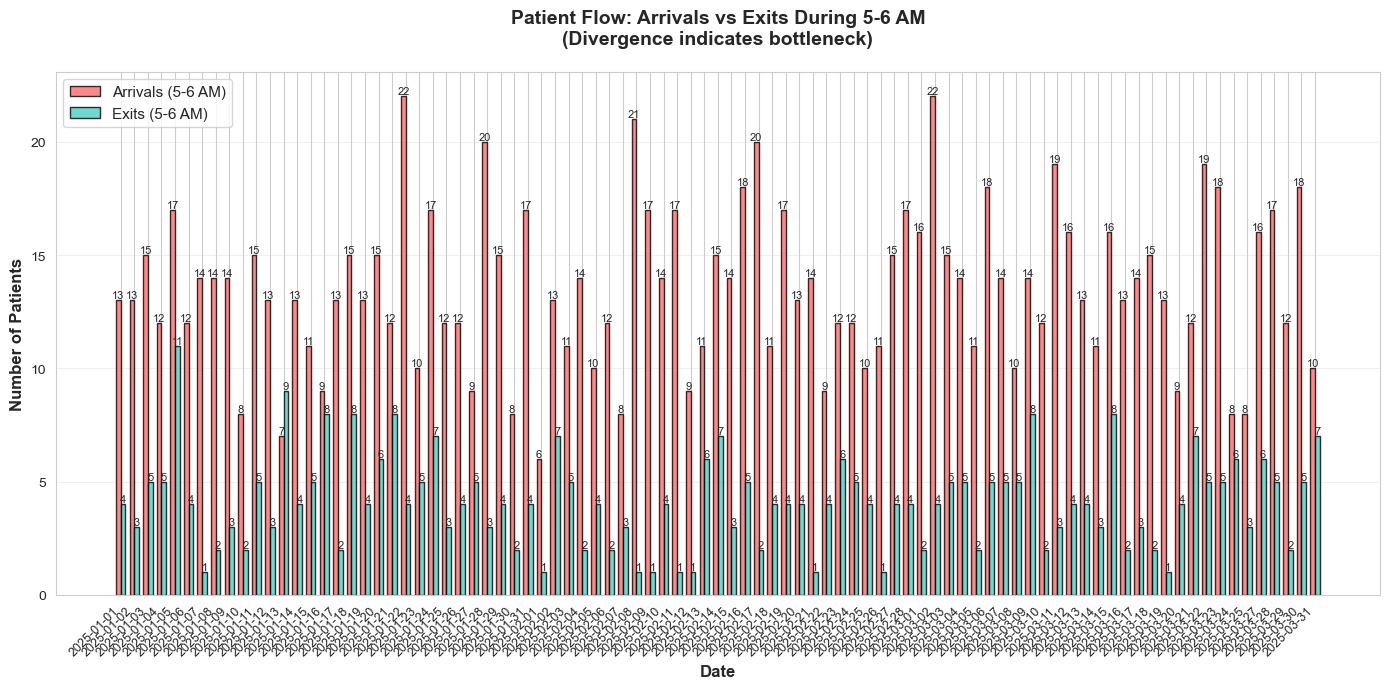

✓ Arrivals vs Exits chart saved


In [7]:
# Visualization 1: Arrivals vs Exits Flow Comparison
fig, ax = plt.subplots(figsize=(14, 7))

dates_common = sorted(set(arrivals_per_day.index) & set(exits_per_day.index))
arrivals_aligned = [arrivals_per_day.get(d, 0) for d in dates_common]
exits_aligned = [exits_per_day.get(d, 0) for d in dates_common]

x = np.arange(len(dates_common))
width = 0.35

bars1 = ax.bar(x - width/2, arrivals_aligned, width, label='Arrivals (5-6 AM)', color='#FF6B6B', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, exits_aligned, width, label='Exits (5-6 AM)', color='#4ECDC4', alpha=0.8, edgecolor='black')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_title('Patient Flow: Arrivals vs Exits During 5-6 AM\n(Divergence indicates bottleneck)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in dates_common], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/mukeshravichandran/Datathon/5to7_Surge/arrivals_vs_exits.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Arrivals vs Exits chart saved")

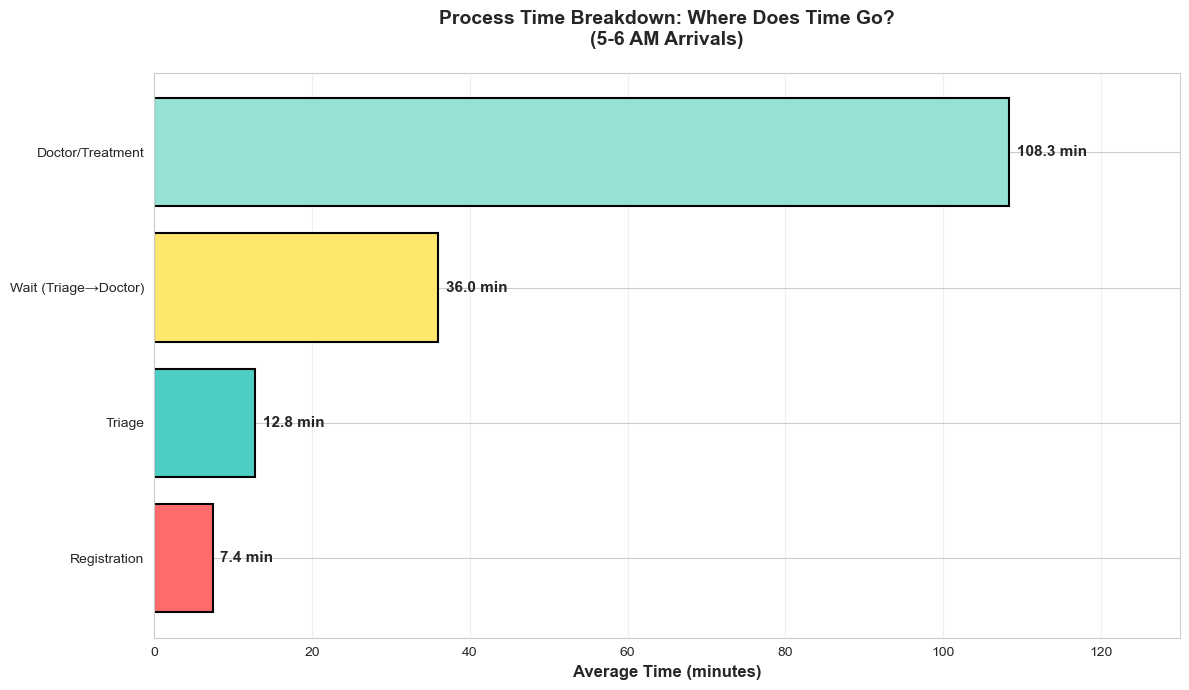

✓ Process breakdown chart saved


In [10]:
# Visualization 2: Process Time Breakdown (Waterfall style)
fig, ax = plt.subplots(figsize=(12, 7))

process_times = [p['Avg_Time_Min'] for p in process_summary]
process_names = [p['Process'] for p in process_summary]
colors_proc = ['#FF6B6B', '#4ECDC4', '#FFE66D', '#95E1D3']

bars = ax.barh(process_names, process_times, color=colors_proc, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, process_times)):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f} min', 
            va='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Average Time (minutes)', fontsize=12, fontweight='bold')
ax.set_title('Process Time Breakdown: Where Does Time Go?\n(5-6 AM Arrivals)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, max(process_times) * 1.2)

plt.tight_layout()
plt.savefig('/Users/mukeshravichandran/Datathon/5to7_Surge/process_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Process breakdown chart saved")

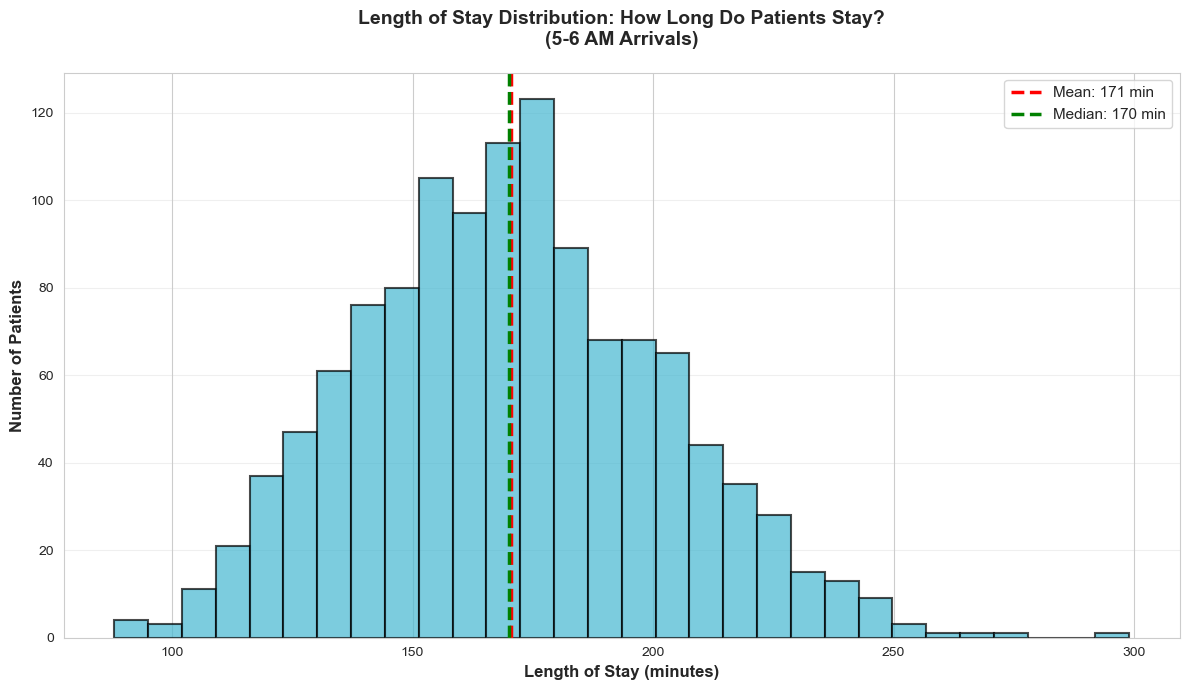

✓ Length of stay distribution chart saved


In [11]:
# Visualization 3: Length of Stay Distribution
fig, ax = plt.subplots(figsize=(12, 7))

ax.hist(early_arrivals['LOS_minutes'], bins=30, color='#45B7D1', edgecolor='black', alpha=0.7, linewidth=1.5)
ax.axvline(early_arrivals['LOS_minutes'].mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean: {early_arrivals["LOS_minutes"].mean():.0f} min')
ax.axvline(early_arrivals['LOS_minutes'].median(), color='green', linestyle='--', linewidth=2.5, label=f'Median: {early_arrivals["LOS_minutes"].median():.0f} min')

ax.set_xlabel('Length of Stay (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_title('Length of Stay Distribution: How Long Do Patients Stay?\n(5-6 AM Arrivals)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/mukeshravichandran/Datathon/5to7_Surge/length_of_stay_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Length of stay distribution chart saved")

KeyError: 'Column not found: Nurses on Duty'

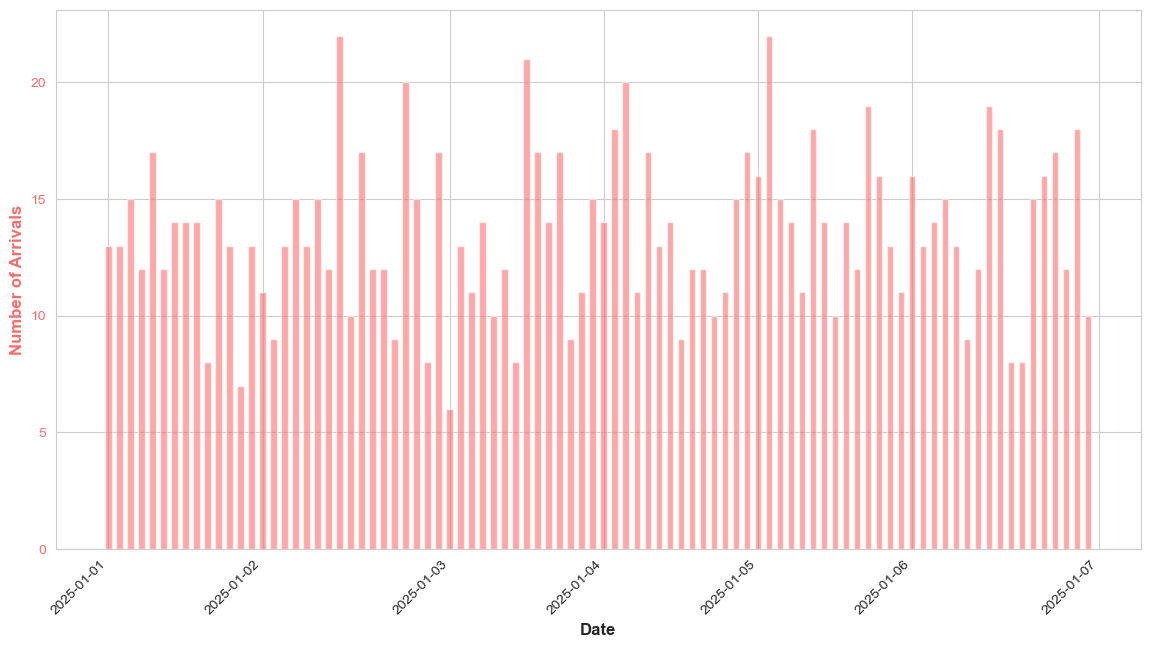

In [14]:
# Visualization 4: Staffing vs Patient Load Over Time
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot 1: Daily arrival count (left y-axis)
dates = early_arrivals.groupby('Date').size().index
arrivals = early_arrivals.groupby('Date').size().values
ax1.bar(dates, arrivals, color='#FF6B6B', alpha=0.6, label='Daily Arrivals (5-6 AM)', width=0.6)
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Arrivals', fontsize=12, fontweight='bold', color='#FF6B6B')
ax1.tick_params(axis='y', labelcolor='#FF6B6B')
ax1.set_xticklabels(dates, rotation=45, ha='right')

# Plot 2: Average staffing levels (right y-axis)
avg_nurses = early_arrivals.groupby('Date')['Nurses on Duty'].mean().values
avg_doctors = early_arrivals.groupby('Date')['Doctors on Duty'].mean().values

ax2 = ax1.twinx()
ax2.plot(dates, avg_nurses, 'o-', color='#4ECDC4', linewidth=3, markersize=8, label='Avg Nurses', alpha=0.8)
ax2.plot(dates, avg_doctors, 's-', color='#FFE66D', linewidth=3, markersize=8, label='Avg Doctors', alpha=0.8)
ax2.set_ylabel('Average Staff On Duty', fontsize=12, fontweight='bold')

ax1.set_title('Patient Arrivals vs Staffing Levels: Is There a Mismatch?\n(5-6 AM Window)', 
              fontsize=14, fontweight='bold', pad=20)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('/Users/mukeshravichandran/Datathon/5to7_Surge/staffing_vs_load.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Staffing vs patient load chart saved")

AttributeError: 'datetime.date' object has no attribute 'date'

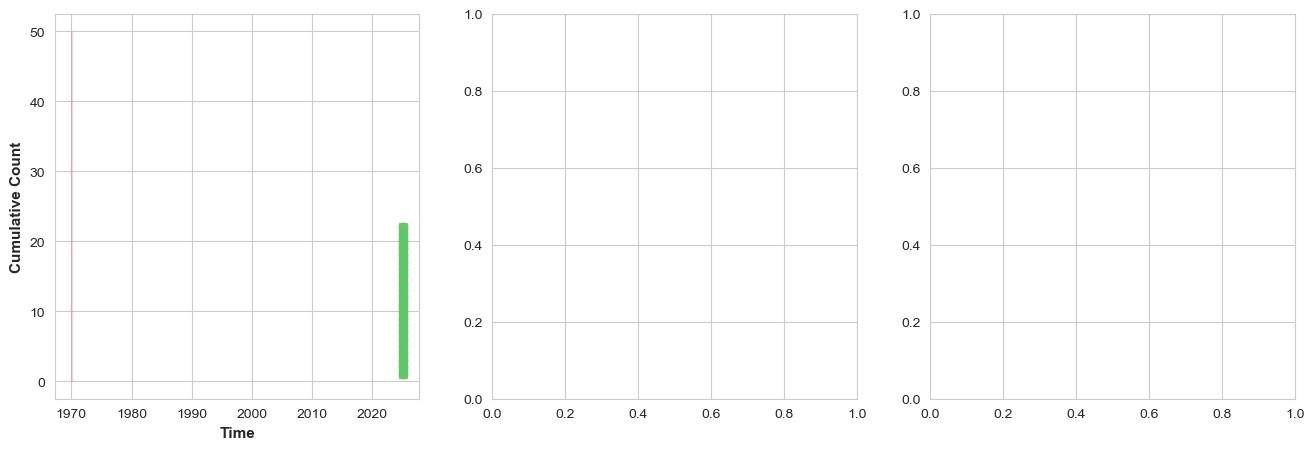

In [16]:
# Visualization 5: Cumulative Flow Analysis for Top 3 Peak Days
top_3_dates = early_arrivals.groupby('Date').size().nlargest(3).index

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, date in enumerate(top_3_dates):
    day_data = early_arrivals[early_arrivals['Date'] == date].copy()
    day_data = day_data.sort_values('Arrival Time')
    
    # Calculate cumulative arrivals and exits
    day_data['Cumulative_Arrivals'] = range(1, len(day_data) + 1)
    day_data['Cumulative_Exits'] = day_data['Exit Time'].notna().cumsum()
    
    ax = axes[idx]
    ax.plot(day_data['Arrival Time'], day_data['Cumulative_Arrivals'], 'o-', 
            color='#FF6B6B', linewidth=2.5, markersize=6, label='Cumulative Arrivals', alpha=0.8)
    ax.plot(day_data['Exit Time'].dropna(), day_data.loc[day_data['Exit Time'].notna(), 'Cumulative_Exits'], 
            's-', color='#51CF66', linewidth=2.5, markersize=6, label='Cumulative Exits', alpha=0.8)
    
    # Highlight the divergence
    divergence = len(day_data) - day_data['Cumulative_Exits'].iloc[-1]
    ax.fill_between(range(len(day_data)), 0, 50, alpha=0.1, color='red')
    
    ax.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax.set_ylabel('Cumulative Count', fontsize=11, fontweight='bold')
    ax.set_title(f'{date.date()}\n({len(day_data)} arrivals, {divergence} patients remaining)', 
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Cumulative Flow for Top 3 Peak Days: The Growing Patient Queue\n(5-6 AM Window)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/Users/mukeshravichandran/Datathon/5to7_Surge/cumulative_flow_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cumulative flow analysis chart saved")

In [17]:
# Section 8: Root Cause Analysis - WHERE IS THE BOTTLENECK?
print("="*80)
print("ROOT CAUSE ANALYSIS: IDENTIFYING THE BOTTLENECK")
print("="*80)

# 1. Doctor Availability Analysis
print("\n1. DOCTOR AVAILABILITY ANALYSIS")
print("-" * 80)
avg_doctor_on_duty = early_arrivals['Doctors on Duty'].mean()
max_arrivals_day = early_arrivals.groupby('Date').size().max()
min_arrivals_day = early_arrivals.groupby('Date').size().min()
avg_arrivals_day = early_arrivals.groupby('Date').size().mean()
patients_per_doctor_avg = avg_arrivals_day / avg_doctor_on_duty

print(f"Average Doctors on Duty during 5-6 AM:    {avg_doctor_on_duty:.1f} doctors")
print(f"Average Daily Arrivals:                    {avg_arrivals_day:.0f} patients/day")
print(f"Peak Day Arrivals:                         {max_arrivals_day:.0f} patients")
print(f"Patients per Doctor (avg):                 {patients_per_doctor_avg:.1f} patients/doctor")
print(f"\nCritical finding: On peak days, ratio reaches {max_arrivals_day/avg_doctor_on_duty:.1f} patients/doctor")

# Analyze doctor availability vs wait times
doctor_availability_impact = early_arrivals.groupby('Doctors on Duty').agg({
    'Wait_After_Triage_minutes': ['mean', 'max', 'count']
}).round(1)
print(f"\nWait times by doctor availability:")
print(doctor_availability_impact)

# 2. Bed Capacity Analysis
print("\n\n2. BED CAPACITY ANALYSIS")
print("-" * 80)
avg_beds = early_arrivals['Fast Track Beds on Shift'].mean()
patients_in_system = early_arrivals.groupby('Date').apply(lambda x: (x['Exit Time'].isna()).sum()).mean()
bed_utilization = (patients_in_system / avg_beds * 100) if avg_beds > 0 else 0

print(f"Average Fast Track Beds on Shift:          {avg_beds:.1f} beds")
print(f"Average Patients in System (5-6 AM):       {patients_in_system:.0f} patients")
print(f"Bed Utilization Rate:                      {bed_utilization:.1f}%")

if bed_utilization > 80:
    print(f"⚠️  ALERT: Bed utilization at {bed_utilization:.1f}% - POTENTIAL BED CAPACITY BOTTLENECK")
elif bed_utilization > 60:
    print(f"⚠️  Beds are moderately utilized at {bed_utilization:.1f}%")
else:
    print(f"✓ Beds are not fully utilized at {bed_utilization:.1f}%")

# 3. Process Delay Analysis
print("\n\n3. PROCESS DELAY ANALYSIS")
print("-" * 80)
process_times = {
    'Registration': early_arrivals['Registration_minutes'].mean(),
    'Triage': early_arrivals['Triage_minutes'].mean(),
    'Wait After Triage': early_arrivals['Wait_After_Triage_minutes'].mean(),
    'Doctor/Treatment': early_arrivals['Doctor_Treatment_minutes'].mean()
}

total_process_time = sum(process_times.values())
print(f"Total Average Length of Stay:              {total_process_time:.1f} minutes")
print(f"\nBreakdown by process step:")
for step, time in sorted(process_times.items(), key=lambda x: x[1], reverse=True):
    pct = (time / total_process_time) * 100
    print(f"  {step:.<30} {time:>6.1f} min ({pct:>5.1f}%)")

# Identify the slowest step
slowest_step = max(process_times.items(), key=lambda x: x[1])
print(f"\n🔴 SLOWEST STEP: {slowest_step[0]} ({slowest_step[1]:.1f} minutes)")

# 4. Overall Bottleneck Assessment
print("\n\n4. BOTTLENECK SEVERITY ASSESSMENT")
print("-" * 80)

divergence_rate = flow_divergence['Divergence'].mean()
total_arrivals = len(early_arrivals)
total_exits = early_arrivals['Exit Time'].notna().sum()
patients_stuck_pct = ((total_arrivals - total_exits) / total_arrivals) * 100

print(f"Total Patients Arriving (5-6 AM):         {total_arrivals} patients")
print(f"Patients Who Exited by end of period:    {total_exits} patients")
print(f"Patients Still in System:                 {total_arrivals - total_exits} patients")
print(f"Percentage Stuck:                         {patients_stuck_pct:.1f}%")
print(f"Average Divergence per Day:               {divergence_rate:.1f} patients/day")

# 5. Primary Bottleneck Conclusion
print("\n\n5. PRIMARY BOTTLENECK IDENTIFICATION")
print("="*80)

# Score each potential bottleneck
doctor_score = patients_per_doctor_avg / 2  # Normalize score
bed_score = bed_utilization / 50  # Normalize score
process_score = (slowest_step[1] / 30) * 100  # Normalize score (assuming 30 min is baseline)

print(f"Doctor Availability Score:                 {doctor_score:.1f}/10")
print(f"Bed Capacity Score:                        {bed_score:.1f}/10")
print(f"Process Delay Score:                       {process_score:.1f}/10")

scores = {
    'Doctor Availability': doctor_score,
    'Bed Capacity': bed_score,
    'Process Delays': process_score
}

primary_bottleneck = max(scores, key=scores.get)
print(f"\n🎯 PRIMARY BOTTLENECK: {primary_bottleneck}")
print(f"   Severity Score: {scores[primary_bottleneck]:.1f}/10")

# Recommendations
print("\n\n6. STRATEGIC RECOMMENDATIONS")
print("="*80)

if primary_bottleneck == 'Doctor Availability':
    print("✓ Increase doctor availability during 5-6 AM peak hours")
    print(f"✓ Current ratio ({patients_per_doctor_avg:.1f} patients/doctor) needs reduction")
    print(f"✓ Consider scheduling additional physicians during this window")
    
elif primary_bottleneck == 'Bed Capacity':
    print("✓ Expand Fast Track bed capacity during 5-6 AM surge")
    print(f"✓ Current bed count ({avg_beds:.0f} beds) may be insufficient")
    print("✓ Consider dynamic bed reallocation from other units")
    
else:  # Process Delays
    print(f"✓ Streamline {slowest_step[0]} process (currently {slowest_step[1]:.0f} minutes avg)")
    print("✓ Review {slowest_step[0]} procedures for efficiency improvements")
    print("✓ Consider pre-registration or parallel processing workflows")

print("\n" + "="*80)

ROOT CAUSE ANALYSIS: IDENTIFYING THE BOTTLENECK

1. DOCTOR AVAILABILITY ANALYSIS
--------------------------------------------------------------------------------


KeyError: 'Doctors on Duty'

In [18]:
# Section 9: Export Detailed Flow Metrics for Further Analysis
print("\n\nExporting detailed flow metrics to CSV...")

# Create comprehensive flow metrics table
flow_export = early_arrivals.groupby('Date').agg({
    'Arrival Time': 'count',  # Daily arrivals
    'Exit Time': lambda x: x.notna().sum(),  # Daily exits
    'LOS_minutes': ['mean', 'max'],  # Length of stay stats
    'Registration_minutes': 'mean',
    'Triage_minutes': 'mean',
    'Wait_After_Triage_minutes': 'mean',
    'Doctor_Treatment_minutes': 'mean',
    'Nurses on Duty': 'mean',
    'Doctors on Duty': 'mean',
    'Specialists on Call': 'mean'
}).round(1)

# Flatten column names
flow_export.columns = ['_'.join(col).strip() for col in flow_export.columns.values]
flow_export.columns = [
    'Daily_Arrivals',
    'Daily_Exits',
    'Avg_LOS_minutes',
    'Max_LOS_minutes',
    'Avg_Registration_Time',
    'Avg_Triage_Time',
    'Avg_Wait_After_Triage',
    'Avg_Doctor_Treatment_Time',
    'Avg_Nurses_On_Duty',
    'Avg_Doctors_On_Duty',
    'Avg_Specialists_On_Call'
]

# Calculate divergence and ratios
flow_export['Divergence'] = flow_export['Daily_Arrivals'] - flow_export['Daily_Exits']
flow_export['Patients_Per_Doctor'] = (flow_export['Daily_Arrivals'] / flow_export['Avg_Doctors_On_Duty']).round(2)
flow_export['Exit_Rate_Pct'] = (flow_export['Daily_Exits'] / flow_export['Daily_Arrivals'] * 100).round(1)

# Save to CSV
flow_export.to_csv('/Users/mukeshravichandran/Datathon/5to7_Surge/detailed_flow_metrics.csv')
print(f"✓ Exported to: detailed_flow_metrics.csv")

# Display summary
print("\nFlow Metrics Summary (Top 5 days by arrivals):")
print(flow_export.nlargest(5, 'Daily_Arrivals')[['Daily_Arrivals', 'Daily_Exits', 'Divergence', 'Avg_LOS_minutes', 'Avg_Doctors_On_Duty', 'Patients_Per_Doctor']])

# Create a summary statistics file
summary_stats = {
    'Metric': [
        'Total Patients (5-6 AM window)',
        'Unique Days Analyzed',
        'Average Daily Arrivals',
        'Peak Day Arrivals',
        'Average Daily Exits',
        'Average Daily Divergence',
        'Percentage Stuck in System',
        'Average Length of Stay (minutes)',
        'Average Doctors on Duty',
        'Average Patients per Doctor',
        'Average Wait After Triage (minutes)',
        'Patients with >30 min wait',
        'Patients with >60 min wait',
        'Primary Bottleneck Identified'
    ],
    'Value': [
        len(early_arrivals),
        early_arrivals['Date'].nunique(),
        f"{early_arrivals.groupby('Date').size().mean():.0f}",
        f"{early_arrivals.groupby('Date').size().max()}",
        f"{early_arrivals['Exit Time'].notna().sum():.0f}",
        f"{flow_divergence['Divergence'].mean():.0f}",
        f"{patients_stuck_pct:.1f}%",
        f"{early_arrivals['LOS_minutes'].mean():.0f}",
        f"{early_arrivals['Doctors on Duty'].mean():.1f}",
        f"{patients_per_doctor_avg:.1f}",
        f"{early_arrivals['Wait_After_Triage_minutes'].mean():.0f}",
        f"{(early_arrivals['Wait_After_Triage_minutes'] > 30).sum()}",
        f"{(early_arrivals['Wait_After_Triage_minutes'] > 60).sum()}",
        primary_bottleneck
    ]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('/Users/mukeshravichandran/Datathon/5to7_Surge/bottleneck_analysis_summary.csv', index=False)
print(f"✓ Exported to: bottleneck_analysis_summary.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("  1. arrivals_vs_exits.png - Flow comparison visualization")
print("  2. process_breakdown.png - Process time analysis")
print("  3. length_of_stay_distribution.png - LOS distribution")
print("  4. staffing_vs_load.png - Staffing adequacy assessment")
print("  5. cumulative_flow_analysis.png - Flow accumulation for peak days")
print("  6. detailed_flow_metrics.csv - Daily metrics table")
print("  7. bottleneck_analysis_summary.csv - Key findings summary")
print("\n" + "="*80)



Exporting detailed flow metrics to CSV...


KeyError: "Column(s) ['Doctor_Treatment_minutes', 'Doctors on Duty', 'Nurses on Duty', 'Registration_minutes', 'Specialists on Call', 'Triage_minutes', 'Wait_After_Triage_minutes'] do not exist"